In [13]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                # ONLY for test data NOT for actual 
        #         noNan_df = df[:10] 
        #         data.append(noNan_df)
                # uncomment line below for ACTUAL data 
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'

        
    
    return input_data

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = getUnitConveredData(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
            
#             print(subjID, duration, sequenceName)
            
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    # remove participants data if the participant's missed trial count is 10% or more of num_trials
    threshold = math.floor(256 * 0.1)
#     print("Missing Trial Count Threshold: ", threshold)
    remove_ids = []
    for key in missedTrials_participants:
        if missedTrials_participants[key] >= threshold:
            remove_ids.append(key)
#     print("Participants that are removed: ", remove_ids)

    for index, row in input_data.iterrows():
        if row['subjID'] in remove_ids:
            input_data.drop(index, inplace=True)

    # Note if a particular participant, duration, or sequence has maximum missing trials
    # ** If the participant had no missed trials, then ID will not show up in dict 
#     print("Missed Trials")
#     print(missedTrials_participants)
#     print(missedTrials_durations)
#     print(missedTrials_sequences)
    
    return input_data



def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

def roundActualDepth(datafolder):
    """
    Round Actual Depth value to nearest tenth
    - Actual depth values from the Kinect are very specific (ex. 3.128)
    - Need to round to calculate meaningful outlier params 
    """
    data = durationDfs(datafolder)
    
    for duration in data:
        for idx, row in duration.iterrows():
            actual_depth = row['actual_depth']
            rounded_depth = round(actual_depth,1) # round depth to the nearest tenth
            duration.at[idx,'actual_depth'] = rounded_depth      
        
    return data

def removeIncorrectlyTaggedImageTrials(datafolder):
    """
    Kinect depth tagging is incorrect 
    Not caught by previous effort to remove targets that are on the floor or wall 
    because the target is on a chair that is flush with the wall.
    
    """
    
    data = roundActualDepth(datafolder)
    
    remove_images = ['depth_duration_stimuli/001559_6/001559_6-target.png',
                 'depth_duration_stimuli/003532_7/003532_7-target.png',
                 'depth_duration_stimuli/003185_5/003185_5-target.png', 
                 'depth_duration_stimuli/003532_7/003532_7-target.png',
                 'depth_duration_stimuli/002062_5/002062_5-target.png', 
                 'depth_duration_stimuli/000222_6/000222_6-target.png',
                 'depth_duration_stimuli/003450_6/003450_6-target.png',
                 'depth_duration_stimuli/000689_7/000689_7-target.png',
                 'depth_duration_stimuli/001502_5/001502_5-target.png',
                 'depth_duration_stimuli/000521_11/000521_11-target.png',
                 'depth_duration_stimuli/002478_8/002478_8-target.png',
                 'depth_duration_stimuli/001056_5/001056_5-target.png',
                 'depth_duration_stimuli/000736_7/000736_7-target.png',
                 'depth_duration_stimuli/002875_13/002875_13-target.png',
                 'depth_duration_stimuli/003396_3/003396_3-target.png']
    for df in data:
        for index, row in df.iterrows():
            if row['stimulus'] in remove_images:
                df.drop(index, inplace=True)
    
    return data 


### Explore tilt

In [2]:
def yaw(matrixtext):
    x21 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[0].split(' ')[0])
    return math.degrees(np.arctan(x21 / x11))

In [3]:
def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def get_yaw(img_num, rootdir):
    """
    Args:
        img_num: mother image number
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png, img_num = 003396_3
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        text = open(extpath + '/' + fname).read()
                        yaw_val = yaw(text)
                        return yaw_val 
        
def experiment_stimuli(data):
    """
    Return list of stimuli used in the experiment 
    """
    df = pd.concat(data)
    stimuli = set(df['stimulus'])
    
    return list(stimuli)

def tilt_distribution(stimuli, rootdir):
    yaws = []
    for stim in stimuli:
        num = get_img_number(stim)
        yaw_val = get_yaw(num, rootdir)
        yaws.append(yaw_val)
    
    plt.xlim([-0.5, 0.5])
    plt.hist(yaws, bins=30, alpha=0.9)
    plt.title('Distribution of Yaw values')
    plt.xlabel('Yaw (degrees)')
    plt.ylabel('count')

    plt.show()

    return yaws 


In [4]:
path = '/Users/prachi/Documents/depth_duration/analysis/data'

# avgEstim_cleaned = '/Users/prachi/Documents/depth_duration/analysis/data_avgEstim_cleaned'

# raw_cleaned_data  = removeIncorrectlyTaggedImageTrials(avgEstim_cleaned)

raw_data = removeIncorrectlyTaggedImageTrials(path)

1010


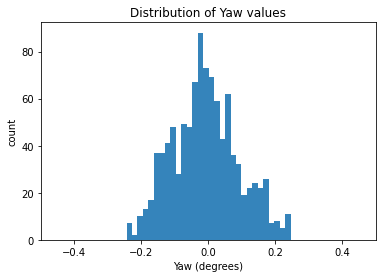

In [397]:
path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'


stim = experiment_stimuli(raw_data)
print(len(stim))

list_of_yaw = tilt_distribution(stim, path)

### Data Analysis

In [5]:
#Outlier Cleaning - Participant level 
import collections

def get_participant_ids(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

def get_participant_average_std(df, subjID):
    """
    Calculate participant's average depth estimate (across duration)
    Calculate participant's std (across duration)
    
    """
    # concatenate all duration dfs
    subj_trials = pd.concat(df, ignore_index=True)
    avg = subj_trials["depth_estimate"].mean()
    std = subj_trials["depth_estimate"].std()
    
    return avg, std

def participant_OutlierRemoval(df):
    '''
    Each participant's average depth estimation is calculated (across duration).
    Calculate outlier range: (-3SD, +3SD) --> if an estimate is outside that participant's range, then remove as outlier
    Removes participants that have 10% or more missing trials 
    
    Args:
        df = [df_250, df_500, df_750, df_1000]
        
    Returns:
        [Data before outliers were removed, Data with outliers removed according to guidelines stated above.] 
        Data is in this format: [df_250, df_500, df_750, df_1000]
    '''
    
    participant_ids = get_participant_ids(df) #calls function to get a list of participant IDs 

    new_df = [] #updated dataframes are added to this list 
    for duration_df in df:
        duration_participant_dfs = []
        for p_id in participant_ids: #calculate average, standard deviation, and outlier parameters for each participant 
            select_participant = duration_df.where(duration_df["subjID"] == p_id) #selects rows by participant ID 
            p_avg, p_std = get_participant_average_std(df, p_id)
            
            new_participant = select_participant
            new_participant["Participant's Average"] = p_avg
            new_participant["Participant's StDev"] = p_std
            
            avg_minus_3SD = p_avg - (3 * p_std)
            avg_plus_3SD = p_avg + (3 * p_std)
            new_participant["Avg-3SD"] = avg_minus_3SD
            new_participant["Avg+3SD"] = avg_plus_3SD
            
            new_participant = new_participant.dropna() #remove all rows with NaN 
            duration_participant_dfs.append(new_participant)
        
        new_duration_df = pd.concat(duration_participant_dfs) #combine data for all participants of a specific duration 
        new_df.append(new_duration_df) #add duration dataframe to list of all data frames 
    
    outlier_distribution = {}
    participant_distribution = {}
    for dur in new_df:
        p_outlier_col = [] #list of outlier values in the duration data frame 
        for idx, row in dur.iterrows():
            subj = row['subjID']
            p_actual = row['actual_depth']
            p_estim = row["depth_estimate"]
            p_avg_minus_3SD = row["Avg-3SD"]
            p_avg_plus_3SD = row["Avg+3SD"]
            if p_estim < p_avg_minus_3SD or p_estim > p_avg_plus_3SD: #label as outlier 
                p_outlier_col.append(1)
                if p_actual not in outlier_distribution:
                    outlier_distribution[p_actual] = 1
                else:
                    outlier_distribution[p_actual] += 1
                    
                if subj not in participant_distribution:
                    participant_distribution[subj] = 1
                else:
                    participant_distribution[subj] += 1
            else: #not an outlier 
                p_outlier_col.append(0)
        dur["Outlier"] = p_outlier_col #add values to the data frame 
        
    pre_outlier = new_df.copy()
    post_outlier = new_df.copy()
    
    count_outlier1 = [] #list of outlier removed for each duration 
    for dur in post_outlier: #if the value is an outlier, then remove it 
        indexNames = dur[dur["Outlier"] == 1].index
        dur.drop(indexNames, inplace=True)
        count_outlier1.append(len(indexNames)) #count of number of outliers removed for each duration 
    
#     print("Number of outliers by duration")
#     print(count_outlier1)
#     print("Number of outliers by actual depth")
#     od = collections.OrderedDict(sorted(outlier_distribution.items()))
#     print(od)
#     print("Number of outliers by participant")
#     print(participant_distribution)
    
    # remove participants data if the participant's outlier count is 10% or more of num_trials
    threshold = math.floor(256 * 0.1)
#     print("Outlier Count Threshold: ", threshold)
    remove_ids = []
    for key in participant_distribution:
        if participant_distribution[key] >= threshold:
            remove_ids.append(key)
#     print("Participants that are removed (outlier): ", remove_ids)
    
    for df in post_outlier:
        for index, row in df.iterrows():
            if row['subjID'] in remove_ids:
                df.drop(index, inplace=True)

    dropped_df = [] #new list of dataframes with columns from outlier removal removed 
    for duration_df in post_outlier:
        duration_df = duration_df.drop(["Participant's Average", "Participant's StDev", "Avg-3SD", "Avg+3SD", "Outlier" ], axis = 1)
        dropped_df.append(duration_df)

    return pre_outlier, dropped_df


In [6]:
raw_postOutlier_data = participant_OutlierRemoval(raw_data)[1]


In [550]:
# raw_postOutlier_data[0]

### Remove participants with average depth estimations > 3SD from mean

In [7]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)


In [8]:
subjects = get_subjIDs(raw_postOutlier_data)

print("Post missing trial removal, and outlier removal")
print('N = ' + str(len(subjects)))



Post missing trial removal, and outlier removal
N = 90


In [9]:
def averageEstimHistogram(post_outlier_data, subjectlist):
    subjAverages = []
    subj_removed = []
    
    df = pd.concat(post_outlier_data)
    
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()
        subjAverages.append(avg)            
            
    num_bins = len(subjAverages)
    n, bins, patches = plt.hist(subjAverages, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Average Distance Estimate')
    plt.show()
    
    mids = 0.5*(bins[1:] + bins[:-1])
    probs = n / np.sum(n)

    mean = np.sum(probs * mids)  
    sd = np.sqrt(np.sum(probs * (mids - mean)**2))
    
    print('Mean: ', mean)
    print('Standard Deviation: ', sd)
    threshold = mean + (3 * sd)
    print("Mean + 3SD: ", threshold )
    
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]
        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()
        
        if avg > threshold:
            subj_removed.append(subj)
            
    print("Participants that are removed: ", subj_removed)
    
    cleaned_subjAverages = [avg for avg in subjAverages if avg <= threshold ]
    print("N = ", len(cleaned_subjAverages))
    cleaned_mean = np.mean(np.array(cleaned_subjAverages))
    print("Average Depth Estimate Post-Cleaning: ", cleaned_mean)
    
    for index, row in df.iterrows():
        if row['subjID'] in subj_removed:
            df.drop(index, inplace=True)
    
    data_250ms = df[df['duration'] == 250.0]
    data_500ms = df[df['duration'] == 500.0]
    data_750ms = df[df['duration'] == 750.0]
    data_1000ms = df[df['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]
    

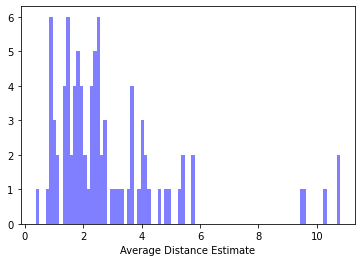

Mean:  2.904618212075342
Standard Deviation:  2.16363652106206
Mean + 3SD:  9.395527775261522
Participants that are removed:  [652326.0, 139458.0, 178385.0, 352586.0, 299971.0]
N =  85
Average Depth Estimate Post-Cleaning:  2.4779054712373956


In [14]:
cleaned_data = averageEstimHistogram(raw_postOutlier_data, subjects)

In [15]:
def avgEstim(data, subjects, condition):
    """
    Calculate average depth estimation either for a duration condition, or all the data
    Args:
    data = cleaned_data
    subjects = list of subjects after
               (1) subjects with more than 10% missing trials are removed
               (2) subjects with more than 10% outlier trials are removed
               (3) subjects with avg estim >= mean + 3SD are removed 
    condition = duration index or None, indicating calculate average across all durations
    Returns:
        Average depth estimation in meters 
    """
    if condition == None:
        df = pd.concat(data)
        avg_estim = np.mean(np.array(df['depth_estimate']))
    else:
        df = data[condition]
        avg_estim = np.mean(np.array(df['depth_estimate']))
        
    
    return avg_estim

In [16]:
subjects = get_subjIDs(cleaned_data)

all_conditions_avgestim = avgEstim(cleaned_data, subjects, None)

avgestim_250 = avgEstim(cleaned_data, subjects, 0)

avgestim_500 = avgEstim(cleaned_data, subjects, 1)

avgestim_750 = avgEstim(cleaned_data, subjects, 2)

avgestim_1000 = avgEstim(cleaned_data, subjects, 3)

avg_estimates = [all_conditions_avgestim, avgestim_250, avgestim_500, avgestim_750, avgestim_1000]

In [707]:
avg_estimates

[2.4814152157674396,
 2.4134765389108725,
 2.4757661981845693,
 2.5213718397603895,
 2.5146685561818867]

In [17]:
def avgActual(data, subjects, condition):
    """
    Calculate average actual depth either for a duration condition, or all the data
    Args:
    data = cleaned_data
    subjects = list of subjects after
               (1) subjects with more than 10% missing trials are removed
               (2) subjects with more than 10% outlier trials are removed
               (3) subjects with avg estim >= mean + 3SD are removed 
    condition = duration index or None, indicating calculate average across all durations
    Returns:
        Average depth estimation in meters 
    """
    if condition == None:
        df = pd.concat(data)
        avg_actual = np.mean(np.array(df['actual_depth']))
    else:
        df = data[condition]
        avg_actual = np.mean(np.array(df['actual_depth']))
        
    
    return avg_actual

In [18]:
subjects = get_subjIDs(cleaned_data)

all_conditions_avg = avgActual(cleaned_data, subjects, None)

avg_250 = avgActual(cleaned_data, subjects, 0)

avg_500 = avgActual(cleaned_data, subjects, 1)

avg_750 = avgActual(cleaned_data, subjects, 2)

avg_1000 = avgActual(cleaned_data, subjects, 3)

avg_actual = [all_conditions_avg, avg_250, avg_500, avg_750, avg_1000]

In [708]:
avg_actual

[3.002351945058564,
 2.9743169398907106,
 3.0002269288956125,
 3.0040059902658185,
 3.03075911311537]

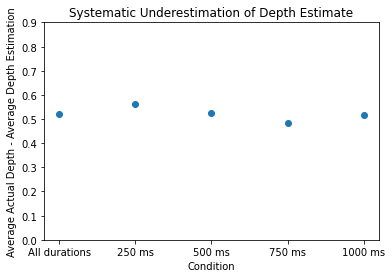

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x = ['All durations', '250 ms', '500 ms', '750 ms', '1000 ms']
y = np.subtract(np.array(avg_actual), np.array(avg_estimates))


plt.scatter(x, y)
plt.yticks(np.arange(0,1, 0.1))
plt.xlabel('Condition')  
plt.ylabel('Average Actual Depth - Average Depth Estimation') 
plt.title('Systematic Underestimation of Depth Estimate')
plt.show()

### Create normalized dfs

In [20]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [21]:
subjects = get_subjIDs(cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 85


In [22]:
def normalize_dfs(data, subjectlist):
    """
    Args:
        data = list of duration dfs after outlier removal 
        subjectlist = list of subjects after outlier removal and filtering by average depth estimation 
    Return:
        norm_data = list of duration dfs after data normalization by particpants average depth estimation
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    df = pd.concat(data) 
    
    norm_subjects = []
    for subj in subjectlist:
        subj_df = df.loc[df['subjID'] == subj]

        # calculate subject's average depth estimation 
        avg = subj_df['depth_estimate'].mean()

        # divide each depth estimate by the subject's average depth estimation 
        subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x/avg)
        
        # TESTING: Alternate normalization method
#         # subtract the participant’s mean from each depth estimate 
#         subj_df['depth_estimate'] = subj_df['depth_estimate'].apply(lambda x:x-avg)

        norm_subjects.append(subj_df)
    
    normalized_df = pd.concat(norm_subjects)
    
    # split into duration 
    data_250ms = normalized_df[normalized_df['duration'] == 250.0]
    data_500ms = normalized_df[normalized_df['duration'] == 500.0]
    data_750ms = normalized_df[normalized_df['duration'] == 750.0]
    data_1000ms = normalized_df[normalized_df['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]


In [23]:
normalized_cleaned_data = normalize_dfs(cleaned_data, subjects)

In [24]:
def pivotTable_post_participant_level_outlier(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each rounded actual depth the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
        
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['actual_depth'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["actual_depth"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        
        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
    
    return result_tables

In [25]:
raw_pivot = pivotTable_post_participant_level_outlier(cleaned_data)
normalized_pivot = pivotTable_post_participant_level_outlier(normalized_cleaned_data)

Double Check Participant Count

In [26]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [27]:
subjects = get_subjIDs(normalized_cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 85


In [28]:
import scipy.stats as stats

def _getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        xs = [x_250, x_500, x_750, x_1000]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    for table in data:
        x = []
        y = []
        ste = []
        for idx, row in table.iterrows():
            x.append(idx) #idx is the actual depth value 
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        
    return xs, ys, stes 



In [29]:
raw_final = _getxy(raw_pivot)
normalized_final = _getxy(normalized_pivot) 

In [30]:
def _createVars(final_data):
    """
    Create variables for final data by duration, for a specific sequence 
    """
    final_x_250 = final_data[0][0]
    final_y_250 = final_data[1][0]
    ste_250 = final_data[2][0]

    final_x_500 = final_data[0][1]
    final_y_500 = final_data[1][1]
    ste_500 = final_data[2][1]

    final_x_750 = final_data[0][2]
    final_y_750 = final_data[1][2]
    ste_750 = final_data[2][2]

    final_x_1000 = final_data[0][3]
    final_y_1000 = final_data[1][3]
    ste_1000 = final_data[2][3]
    
    return [[final_x_250, final_y_250, ste_250], 
            [final_x_500, final_y_500, ste_500], 
            [final_x_750, final_y_750, ste_750], 
            [final_x_1000, final_y_1000, ste_1000]]



In [31]:
raw_final_vars = _createVars(raw_final)
normalized_final_vars = _createVars(normalized_final)

In [32]:
#Calculate the T-test for the means of two independent samples of scores.

#This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
#This test assumes that the populations have identical variances by default.
def _durationStatsTests(finaldata):
    
    final_y_250 = finaldata[0][1]
    final_y_500 = finaldata[1][1]
    final_y_750 = finaldata[2][1]
    final_y_1000 = finaldata[3][1]
    
    print("250ms vs. 500ms")
    ttest_250_500 = stats.ttest_ind(final_y_250,final_y_500)
    print(ttest_250_500)
    print("250ms vs. 750ms")
    ttest_250_750 = stats.ttest_ind(final_y_250,final_y_750)
    print(ttest_250_750)
    print("250ms vs. 1000ms")
    ttest_250_1000 = stats.ttest_ind(final_y_250,final_y_1000)
    print(ttest_250_1000)
    print("500ms vs. 750ms")
    ttest_500_750 = stats.ttest_ind(final_y_500,final_y_750)
    print(ttest_500_750)
    print("500ms vs. 1000ms")
    ttest_500_1000 = stats.ttest_ind(final_y_500,final_y_1000)
    print(ttest_500_1000)
    print("750ms vs. 1000ms")
    ttest_750_1000 = stats.ttest_ind(final_y_750,final_y_1000)
    print(ttest_750_1000)
    
    # stats f_oneway functions takes the groups as input and returns F and P-value
    fvalue, pvalue = stats.f_oneway(final_y_250, final_y_500, final_y_750, final_y_1000)
    print("All durations: fvalue=", fvalue, "pvalue=",pvalue)
    
    return None 

print("Results")
raw_ttests = _durationStatsTests(raw_final_vars)

print('\n')
print("Normalized Results")
normalized_ttests = _durationStatsTests(normalized_final_vars)

Results
250ms vs. 500ms
Ttest_indResult(statistic=-1.062483483345755, pvalue=0.291253404545722)
250ms vs. 750ms
Ttest_indResult(statistic=-0.7333025454822782, pvalue=0.4655444374972523)
250ms vs. 1000ms
Ttest_indResult(statistic=-0.9435652221947186, pvalue=0.3482686421743918)
500ms vs. 750ms
Ttest_indResult(statistic=0.25459351029079047, pvalue=0.7997070977948715)
500ms vs. 1000ms
Ttest_indResult(statistic=0.07273521424282503, pvalue=0.9422030186082682)
750ms vs. 1000ms
Ttest_indResult(statistic=-0.17727352000519336, pvalue=0.8597530860625056)
All durations: fvalue= 0.395365412175819 pvalue= 0.7565106742651189


Normalized Results
250ms vs. 500ms
Ttest_indResult(statistic=-0.979064801917231, pvalue=0.3305367339447097)
250ms vs. 750ms
Ttest_indResult(statistic=-0.8914903955414233, pvalue=0.37537338779398666)
250ms vs. 1000ms
Ttest_indResult(statistic=-1.1827331992591446, pvalue=0.24046224970615082)
500ms vs. 750ms
Ttest_indResult(statistic=0.019533785212243485, pvalue=0.984465167821962)

## One-Way Repeated Measures ANOVA

https://statistics.laerd.com/statistical-guides/repeated-measures-anova-statistical-guide.php

IV conditions: Duration - 250, 500, 750, 1000

IV: Actual Depth

DV: Depth Estimate 

H0: µ1 = µ2 = µ3 = … = µk where µ = population mean and k = number of related groups. 

HA: at least two means are significantly different

In [754]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM


def _subjectData(folderpath, normalize, threshold):
    """
    Analyze data by each subject 
    Returns list of data by subject
    """
    data = []
    for filename in os.listdir(folderpath):
        if 'csv' in filename:
            path = folderpath + "/" + filename
            ############ get data ############
            cleaned_data  = removeIncorrectlyTaggedImageTrials(path)
            # skips participants whose data was removed due to too many outliers or missed trials
            # checks number of rows in df_250 
            if cleaned_data[0].shape[0] > 1:            
                postOutlier_data = participant_OutlierRemoval(cleaned_data)[1]
                
                if normalize == False:
                    subj_df = pd.concat(postOutlier_data)
                    # calculate subject's average depth estimation 
                    subj_avg = subj_df['depth_estimate'].mean()
                    # do not analyze participants with avg depth estimates greater than mean + 3SD
                    if subj_avg <= threshold:
                        pivot = pivotTable_post_participant_level_outlier(postOutlier_data)
                        subj_data = _getxy(pivot)
                        data.append(subj_data)
                        
                if normalize == True:
                    subj_df = pd.concat(postOutlier_data)
                    # calculate subject's average depth estimation 
                    subj_avg = subj_df['depth_estimate'].mean()
                    # do not analyze participants with avg depth estimates greater than mean + 3SD
                    if subj_avg <= threshold:
                        subjects = get_subjIDs(postOutlier_data)
                        normalized_postOutlier_data = normalize_dfs(postOutlier_data, subjects)

                        normalized_pivot = pivotTable_post_participant_level_outlier(normalized_postOutlier_data)
                        normalized_subj_data = _getxy(normalized_pivot) 
                        data.append(normalized_subj_data)

    return data # list of data for all subjects 

def _buildDF_subjectLinReg(folderpath, normalize, threshold):
    """
    Plot slopes for each participant
    """
    
    dict_data_slope = {'participant': [], 'duration': [], 'slope': []}
    
    dict_data_intercept = {'participant': [], 'duration': [], 'intercept': []}
    
    data = _subjectData(folderpath, normalize, threshold)
    durations = [250, 500, 750, 1000]
    participant = 0
    for subject in data:
        for i in range(len(durations)): 
            final_x = subject[0][i]
            final_y = subject[1][i]
            ste = subject[2][i]

            x = np.array(final_x)
            y = np.array(final_y)
            ste = np.array(ste)

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            dict_data_slope['participant'].append(participant)
            dict_data_slope['duration'].append(durations[i])
            dict_data_slope['slope'].append(slope)
            
            dict_data_intercept['participant'].append(participant)
            dict_data_intercept['duration'].append(durations[i])
            dict_data_intercept['intercept'].append(intercept)
        
        participant += 1
            
    df_slope = pd.DataFrame(data=dict_data_slope)
    
    df_intercept = pd.DataFrame(data=dict_data_intercept)
    
    return df_slope, df_intercept

# def _getDurationAvgs(folderpath):
#     df_slope, df_intercept = _buildDF_subjectLinReg(folderpath)
    
#     df_slope_250 = df_slope[df_slope["duration"] == 250]
#     df_slope_500 = df_slope[df_slope["duration"] == 500]
#     df_slope_750 = df_slope[df_slope["duration"] == 750]
#     df_slope_1000 = df_slope[df_slope["duration"] == 1000]
    
#     slope_avgs = {'250': df_slope_250['slope'].mean(),
#                   '500': df_slope_500['slope'].mean(), 
#                   '750': df_slope_750['slope'].mean(),
#                   '1000': df_slope_1000['slope'].mean()}
    
#     df_intercept_250 = df_intercept[df_intercept["duration"] == 250]
#     df_intercept_500 = df_intercept[df_intercept["duration"] == 500]
#     df_intercept_750 = df_intercept[df_intercept["duration"] == 750]
#     df_intercept_1000 = df_intercept[df_intercept["duration"] == 1000]
    
#     intercept_avgs = {'250': df_intercept_250['intercept'].mean(),
#                   '500': df_intercept_500['intercept'].mean(), 
#                   '750': df_intercept_750['intercept'].mean(),
#                   '1000': df_intercept_1000['intercept'].mean()}
    
#     print("Subject Slope Average for each Duration")
#     print(slope_avgs)
    
#     print("Subject Intercept Average for each Duration")
#     print(intercept_avgs)
        

def _repeatedMeasuresANOVA(folderpath, normalize, threshold):

    df_slope = _buildDF_subjectLinReg(folderpath, normalize, threshold)[0]
    print("Dependent variable: Participant Slopes")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_slope, depvar='slope', subject='participant', within=['duration']).fit())
    
    df_intercept = _buildDF_subjectLinReg(folderpath, normalize, threshold)[1]
    print("Dependent variable: Participant Intercepts")
    #perform the repeated measures ANOVA
    print(AnovaRM(data=df_intercept, depvar='intercept', subject='participant', within=['duration']).fit())



path = '/Users/prachi/Documents/depth_duration/analysis/data'

avg_plus_3SD = 9.395527775261522

# Second argument sets if data gets normalized by participants avg depth estimation 
print("Raw Data")
results = _repeatedMeasuresANOVA(path, False, avg_plus_3SD)


print("Normalized Data")
normalized = _repeatedMeasuresANOVA(path, True, avg_plus_3SD)



Raw Data
Dependent variable: Participant Slopes
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 18.5658 3.0000 168.0000 0.0000

Dependent variable: Participant Intercepts
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 12.7826 3.0000 168.0000 0.0000

Normalized Data
Dependent variable: Participant Slopes
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 27.5437 3.0000 168.0000 0.0000

Dependent variable: Participant Intercepts
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
duration 19.5289 3.0000 168.0000 0.0000



### Need to check assumptions

## Plot Duration Slopes

### Raw Data

In [563]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def linreg_duration(x, y, ste, duration):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.4, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "blue")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "blue")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [913]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = raw_final
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.35677572]
b: 1.3359589918576211
R-squared:  0.7226410608095222


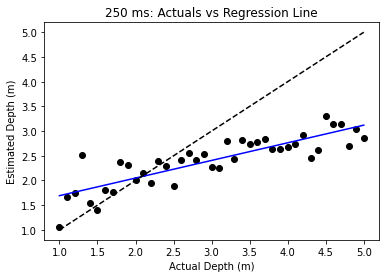

In [914]:
from sklearn.linear_model import LinearRegression
#run regression
X_250 = np.array(final_x_250).reshape(-1,1)
y_250 = final_y_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.plot(X_250, y_250, 'o', color='black');
plt.plot(X_250,y_predicted_250,color='blue')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_250, X_250, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

Text(0, 0.5, 'Residual')

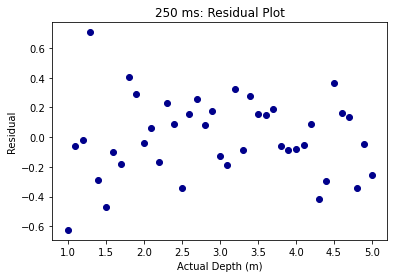

In [923]:
residuals_250 = y_250-y_predicted_250
plt.plot(X_250,residuals_250, 'o', color='darkblue')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

In [299]:
# http://www.hackdeploy.com/python-linear-regression-analysis/
# import statsmodels.api as sm
# est = sm.OLS(y, X)
# est2 = est.fit()
# print(est2.summary())

slope: 0.356776    intercept: 1.335959
R-squared: 0.722641
Standard-error: 0.035393


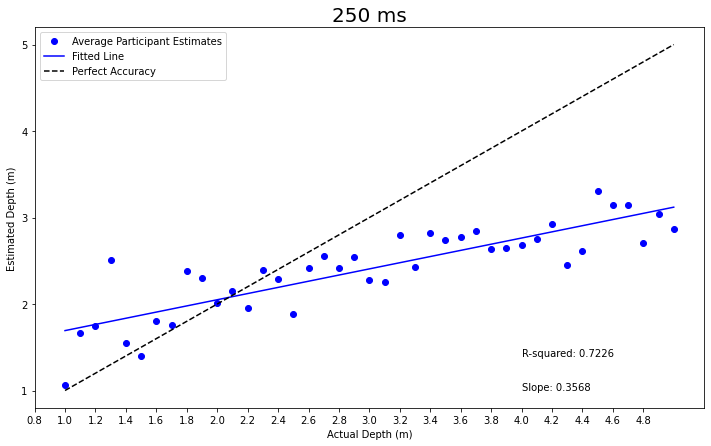

In [441]:
slope_250 = linreg_duration(final_x_250, final_y_250, ste_250, 250)[0]

m: [0.42518285]
b: 1.242545359752519
R-squared:  0.6433066820851411


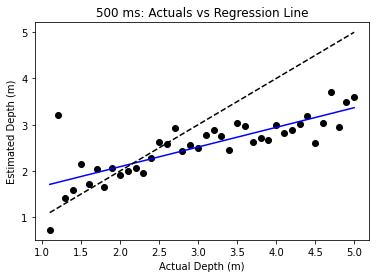

In [915]:
from sklearn.linear_model import LinearRegression
#run regression
X_500 = np.array(final_x_500).reshape(-1,1)
y_500 = final_y_500
reg_500 = LinearRegression().fit(X_500, y_500)

#Generated Predictions
y_predicted_500 = reg_500.predict(X_500)
#Plot Our Actual and Predicted Values
plt.plot(X_500, y_500, 'o', color='black');
plt.plot(X_500,y_predicted_500,color='blue')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_500, X_500, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_500.coef_))
print("b: {0}".format(reg_500.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_500.score(X_500, y_500))

Text(0, 0.5, 'Residual')

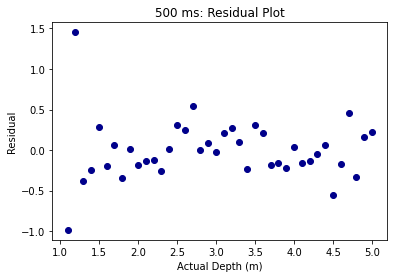

In [924]:
residuals_500 = y_500-y_predicted_500
plt.plot(X_500,residuals_500, 'o', color='darkblue')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.425183    intercept: 1.242545
R-squared: 0.643307
Standard-error: 0.051360


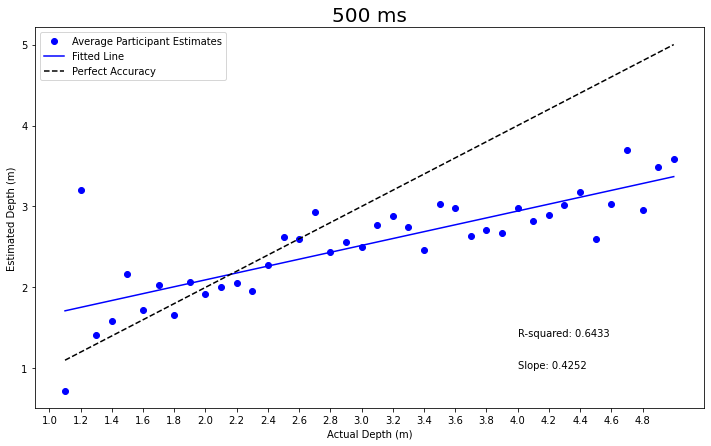

In [444]:
slope_500 = linreg_duration(final_x_500, final_y_500, ste_500, 500)[0]

m: [0.50129737]
b: 0.9736641838608577
R-squared:  0.765632914889675


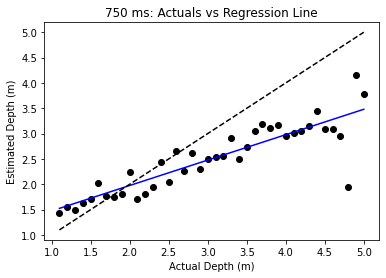

In [917]:
from sklearn.linear_model import LinearRegression
#run regression
X_750 = np.array(final_x_750).reshape(-1,1)
y_750 = final_y_750
reg_750 = LinearRegression().fit(X_750, y_750)

#Generated Predictions
y_predicted_750 = reg_750.predict(X_750)
#Plot Our Actual and Predicted Values
plt.plot(X_750, y_750, 'o', color='black');
plt.plot(X_750,y_predicted_750,color='blue')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_750, X_750, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_750.coef_))
print("b: {0}".format(reg_750.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_750.score(X_750, y_750))

Text(0, 0.5, 'Residual')

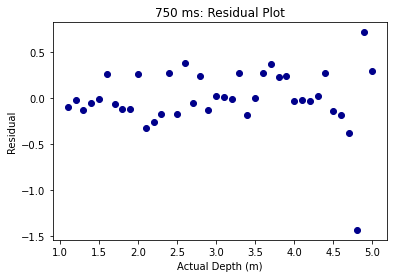

In [920]:
residuals_750 = y_750-y_predicted_750
plt.plot(X_750,residuals_750, 'o', color='darkblue')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.501297    intercept: 0.973664
R-squared: 0.765633
Standard-error: 0.044993


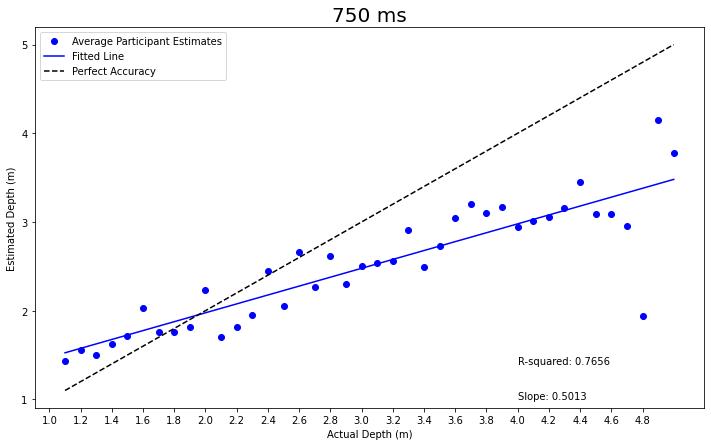

In [447]:
slope_750 = linreg_duration(final_x_750, final_y_750, ste_750, 750)[0]

m: [0.52684258]
b: 0.9220820821436426
R-squared:  0.8742527142546708


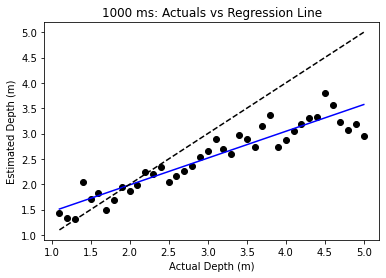

In [921]:
from sklearn.linear_model import LinearRegression
#run regression
X_1000 = np.array(final_x_1000).reshape(-1,1)
y_1000 = final_y_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.plot(X_1000, y_1000, 'o', color='black');
plt.plot(X_1000,y_predicted_1000,color='blue')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

Text(0, 0.5, 'Residual')

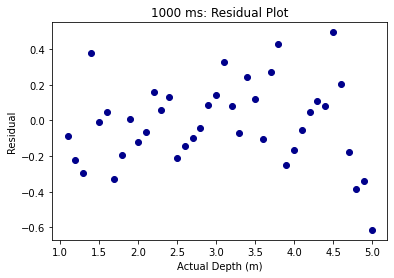

In [922]:
residuals_1000 = y_1000-y_predicted_1000
plt.plot(X_1000,residuals_1000, 'o', color='darkblue')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.526843    intercept: 0.922082
R-squared: 0.874253
Standard-error: 0.032413


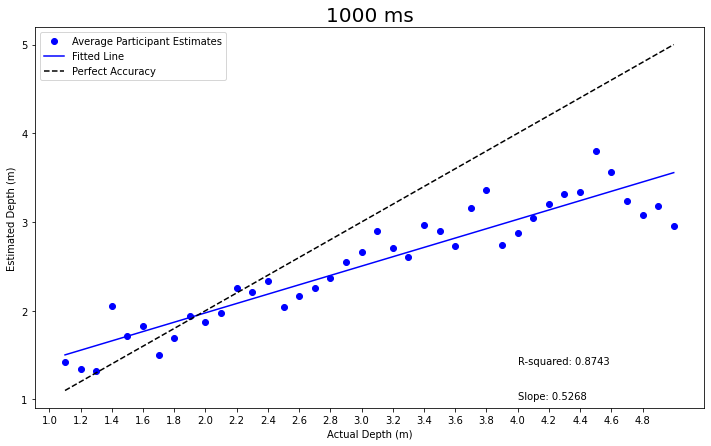

In [450]:
slope_1000 = linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000)[0]

#### Summary Plots for Non-Normalized Data

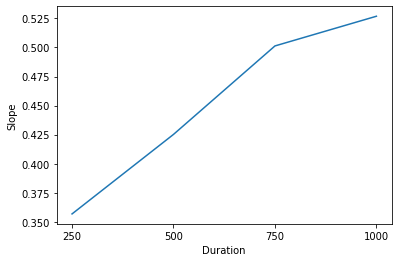

In [451]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.plot(xAxis,slopes)
plt.xlabel('Duration')
plt.ylabel('Slope')
plt.show()

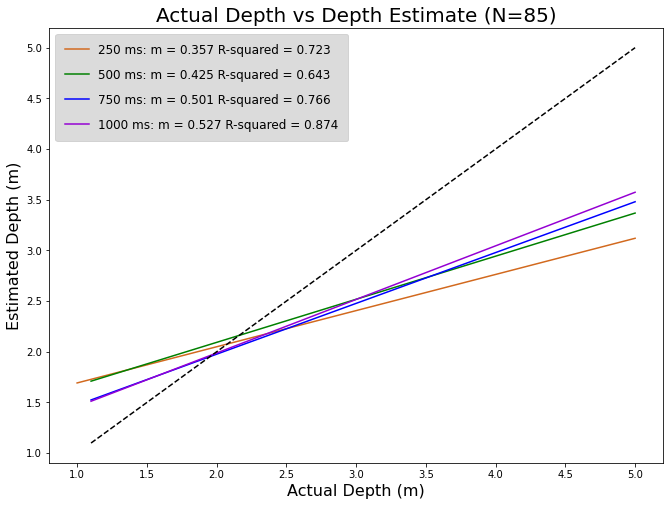

In [989]:
#Plot Our Actual and Predicted Values

plt.figure(figsize = [11, 8])

# plt.plot(X_250, y_250, 'o', color='chocolate');
plt.plot(X_250,y_predicted_250,color='chocolate', label = '250 ms: '
        + "m = " + str(round(reg_250.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_250.score(X_250, y_250), 3)))

# plt.plot(X_500, y_500, 'o', color='green');
plt.plot(X_500,y_predicted_500,color='green', label = '500 ms: '
        + "m = " + str(round(reg_500.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_500.score(X_500, y_500), 3)))

# plt.plot(X_750, y_750, 'o', color='blue');
plt.plot(X_750,y_predicted_750,color='blue', label = '750 ms: '
        + "m = " + str(round(reg_750.coef_[0], 3)) 
        + " R-squared = " + str(round(reg_750.score(X_750, y_750), 3)))

# plt.plot(X_1000, y_1000, 'o', color='darkviolet');
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = '1000 ms: ' 
         + "m = " + str(round(reg_1000.coef_[0], 3)) 
         + " R-squared = " + str(round(reg_1000.score(X_1000, y_1000), 3)))

plt.title("Actual Depth vs Depth Estimate (N=85)", fontsize = 20)
plt.xlabel("Actual Depth (m)", fontsize = 16)
plt.ylabel("Estimated Depth (m)", fontsize = 16)
legend = plt.legend(loc = 0, fontsize = 12, borderpad = 0.8, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.plot(X_1000, X_1000, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid

plt.show()

### Normalized Data

In [570]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normalized_linreg_duration(x, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(x)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.5, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.7, text_r2) 
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "purple")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "purple")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x/avg, label = "Perfect Accuracy Normalized", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

In [571]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
plot_data = normalized_final
avg_average_particip_estim = 2.4779054712373956 # calculated in depthDuration_analysis.ipynb
##############################

final_x_250 = plot_data[0][0]
final_y_250 = plot_data[1][0]
ste_250 = plot_data[2][0]

final_x_500 = plot_data[0][1]
final_y_500 = plot_data[1][1]
ste_500 = plot_data[2][1]

final_x_750 = plot_data[0][2]
final_y_750 = plot_data[1][2]
ste_750 = plot_data[2][2]

final_x_1000 = plot_data[0][3]
final_y_1000 = plot_data[1][3]
ste_1000 = plot_data[2][3]

m: [0.1468505]
b: 0.5247519256452707
R-squared:  0.7941120956428112


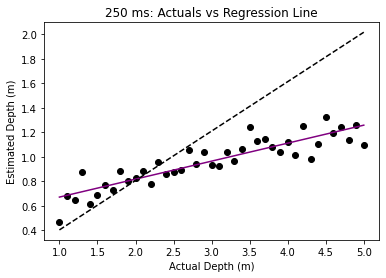

In [572]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(final_x_250).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black');
plt.plot(X,y_predicted,color='purple')
plt.title("250 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

Text(0, 0.5, 'Residual')

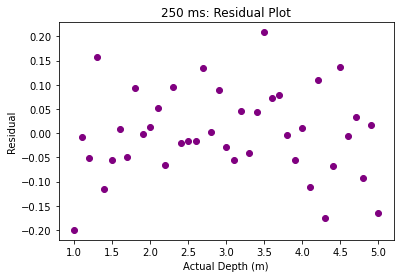

In [573]:
residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='purple')
plt.title("250 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.146851    intercept: 0.524752
R-squared: 0.794112
Standard-error: 0.011973


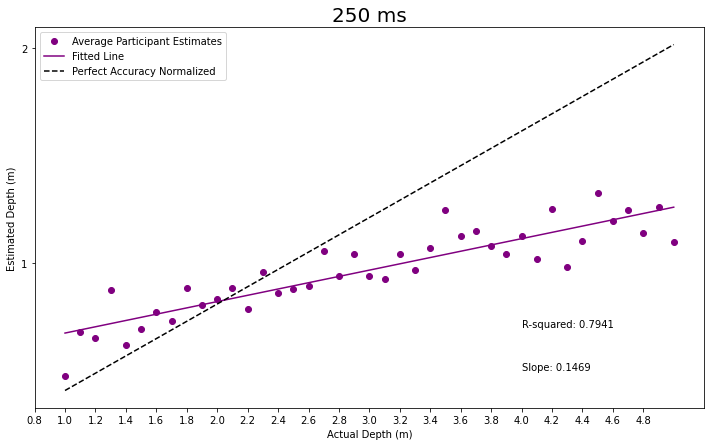

In [574]:
slope_250 = normalized_linreg_duration(final_x_250, final_y_250, ste_250, 250,
                                       avg_average_particip_estim)[0]

m: [0.17529777]
b: 0.4786036456594266
R-squared:  0.7186409019134409


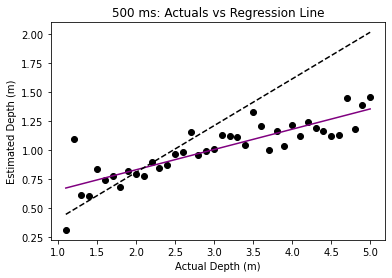

In [457]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(final_x_500).reshape(-1,1)
y = final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black');
plt.plot(X,y_predicted,color='purple')
plt.title("500 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

Text(0, 0.5, 'Residual')

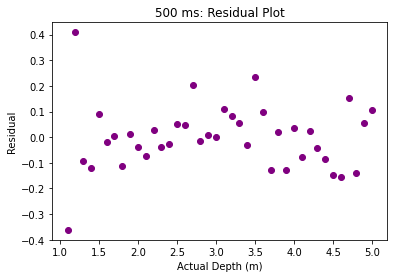

In [458]:
residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='purple')
plt.title("500 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.175298    intercept: 0.478604
R-squared: 0.718641
Standard-error: 0.017793


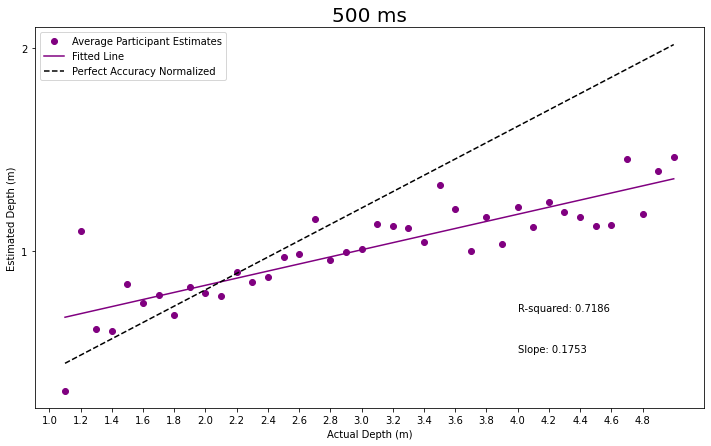

In [459]:
slope_500 = normalized_linreg_duration(final_x_500, final_y_500, ste_500, 500,
                                       avg_average_particip_estim)[0]

m: [0.20745436]
b: 0.37940529667680656
R-squared:  0.8030822799068457


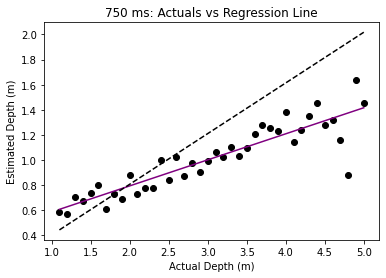

In [460]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(final_x_750).reshape(-1,1)
y = final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black');
plt.plot(X,y_predicted,color='purple')
plt.title("750 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

Text(0, 0.5, 'Residual')

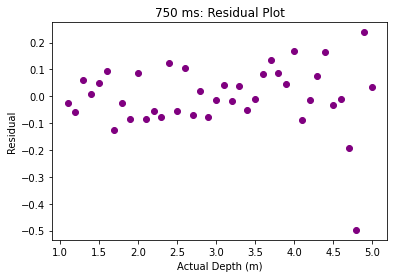

In [461]:
residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='purple')
plt.title("750 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.207454    intercept: 0.379405
R-squared: 0.803082
Standard-error: 0.016665


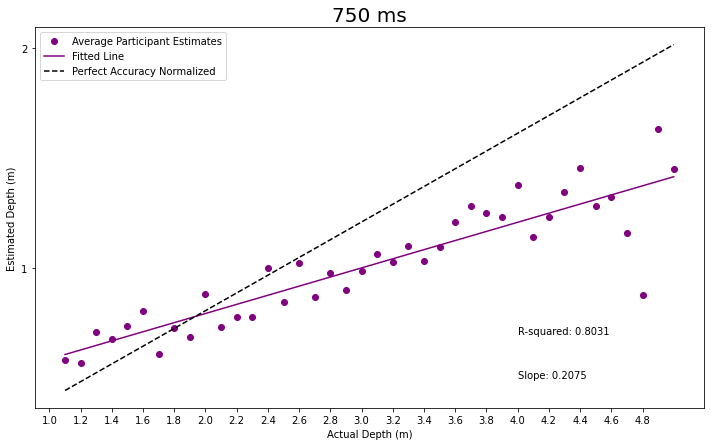

In [462]:
slope_750 = normalized_linreg_duration(final_x_750, final_y_750, ste_750, 750,
                                       avg_average_particip_estim)[0]

m: [0.23181218]
b: 0.3224963152087108
R-squared:  0.907242883744331


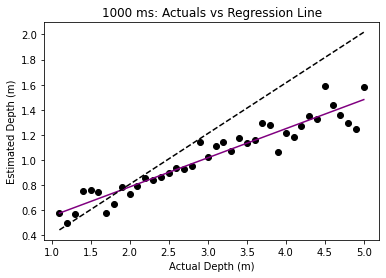

In [463]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(final_x_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
plt.plot(X, y, 'o', color='black');
plt.plot(X,y_predicted,color='purple')
plt.title("1000 ms: Actuals vs Regression Line")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Estimated Depth (m)")
plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

Text(0, 0.5, 'Residual')

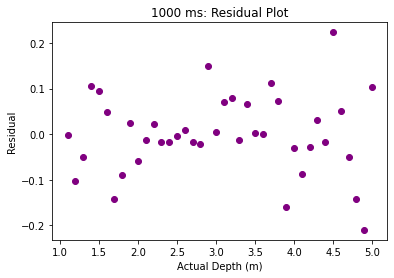

In [464]:
residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='purple')
plt.title("1000 ms: Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

slope: 0.231812    intercept: 0.322496
R-squared: 0.907243
Standard-error: 0.012024


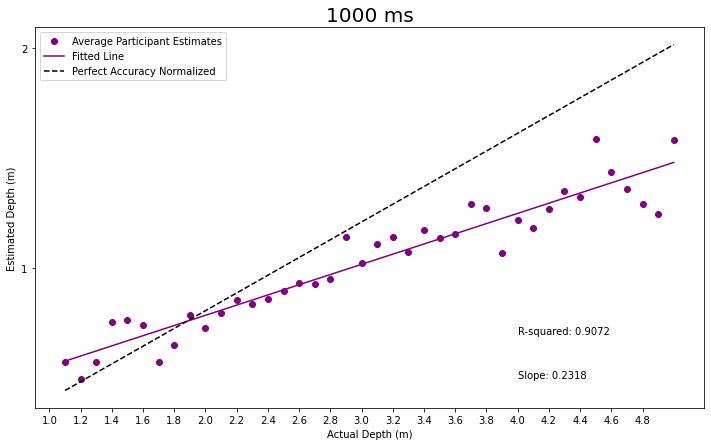

In [466]:
slope_1000 = normalized_linreg_duration(final_x_1000, final_y_1000, ste_1000, 1000,
                                       avg_average_particip_estim)[0]

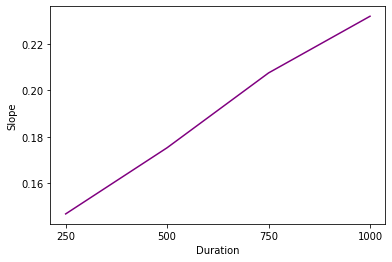

In [467]:
slopes = [slope_250, slope_500, slope_750, slope_1000]
xAxis = ['250', '500', '750', '1000']
plt.plot(xAxis,slopes, color='purple')
plt.xlabel('Duration')
plt.ylabel('Slope')
plt.show()

### Individual Target Results


In [33]:
import pandas as pd 
import scipy.stats as stats


def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    cond = 0
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 250
        if cond == 1:
            result["Duration"] = 500
        if cond == 2:
            result["Duration"] = 750
        if cond == 3:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables



In [34]:
raw_trial_pivot = trial_pivotTable(cleaned_data)
normalized_trial_pivot = trial_pivotTable(normalized_cleaned_data)


In [35]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [250, 500, 750, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_250, x_500, x_750, x_1000]
        xs = [list of individual targets]
        ys = [y_250, y_500, y_750, y_100]
        stes = [ste_250, ste_500, ste_750, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    actualdepths = []
    for table in data:
        x = []
        y = []
        ste = []
        depths = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
    return xs, ys, stes, actualdepths



In [36]:
trial_raw_final = trial_getxy(raw_trial_pivot)
trial_normalized_final = trial_getxy(normalized_trial_pivot)

Double Check Participant Count

In [37]:
def get_subjIDs(df):
    """
    Args:
        df = [df_250, df_500, df_750, df_1000]
        Output from concat_dfs should be the input 
    Returns:
        List of the participant IDs 
    """
# since the participant ids list is the same for all durations just df_250 will be used to get the participant list
    df_250 = df[0]
    participants = set()
    for idx, row in df_250.iterrows():
        participantID = row["subjID"]
        participants.add(participantID)
        
    return list(participants)

In [38]:
subjects = get_subjIDs(cleaned_data)

print("Post missing trial removal, outlier removal, and average depth estimation cleaning")
print('N = ' + str(len(subjects)))



Post missing trial removal, outlier removal, and average depth estimation cleaning
N = 85


#### Raw Data

In [39]:
trial_plot_data = trial_raw_final

## Execute this cell to prep for plotting
final_x_250 = trial_plot_data[0][0]
final_y_250 = trial_plot_data[1][0]
ste_250 = trial_plot_data[2][0]
stim_250 = trial_plot_data[3][0]

final_x_500 = trial_plot_data[0][1]
final_y_500 = trial_plot_data[1][1]
ste_500 = trial_plot_data[2][1]
stim_500 = trial_plot_data[3][1]

final_x_750 = trial_plot_data[0][2]
final_y_750 = trial_plot_data[1][2]
ste_750 = trial_plot_data[2][2]
stim_750 = trial_plot_data[3][2]

final_x_1000 = trial_plot_data[0][3]
final_y_1000 = trial_plot_data[1][3]
ste_1000 = trial_plot_data[2][3]
stim_1000 = trial_plot_data[3][3]

##### Tilt 

In [40]:
def yaw(matrixtext):
    x21 = float(matrixtext.split('\n')[1].split(' ')[0])
    x11 = float(matrixtext.split('\n')[0].split(' ')[0])
    return math.degrees(np.arctan(x21 / x11))

def get_img_number(stimulus_path):
    stim = stimulus_path.split('/')[-1]
    img_num = stim.split('_')[0]
    
    return img_num

def calculate_yaw(path, rootdir):
    """
    Args:
        path: stimulus path as noted in data csv files 
                 ex. 'depth_duration_stimuli/003396_3/003396_3-target.png
        rootdir: kinect2data folder path 
    Uses img_num to find the respective SUNRGBD folder --> uses extrinsics file to calculate yaw
    
    """
    img_num = get_img_number(path)
    for _dir in os.listdir(rootdir):
        split = _dir.split('_')[0]
        if split == img_num:
            path = rootdir + '/' + _dir
            for folder in os.listdir(path):
                if folder != '.DS_Store':
                    extpath = path + '/extrinsics'
                    os.listdir(extpath)
                    fname = os.listdir(extpath)[0]
                    if fname != '.ipynb_checkpoints':
                        text = open(extpath + '/' + fname).read()
                        yaw_val = yaw(text)
                        return yaw_val 

In [41]:
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x --> calculate tilt 

yaw_250 = [calculate_yaw(path, kinectv2_path) for path in final_x_250]
yaw_500 = [calculate_yaw(path, kinectv2_path) for path in final_x_500]
yaw_750 = [calculate_yaw(path, kinectv2_path) for path in final_x_750]
yaw_1000 = [calculate_yaw(path, kinectv2_path) for path in final_x_1000]


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 1, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 1.4, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = "Individual Targets: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "darkgreen")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "darkgreen")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err
    

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_img_ste(actual_depth, y, ste, duration):

    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays actual_depth, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actual_depth)
    y = np.array(ste)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.13, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.15, text_r2)
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 5, step = 0.1))
    plt.title(label = "Individual Target Standard Error: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Standard Error")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "chocolate")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "chocolate")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
#     plt.plot(x, x, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.34600217]
b: 1.403239016475105
R-squared:  0.3271407455743611


Text(0, 0.5, 'Residual')

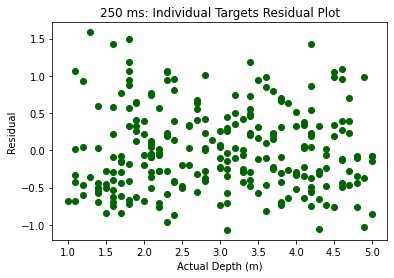

In [1020]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_250).reshape(-1,1)
y = final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

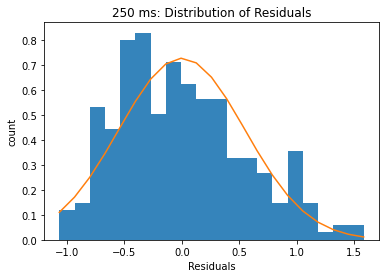

In [1021]:
plt.title('250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_250, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_250 = scipy.stats.norm.pdf(bins, mu_250, sigma)
plt.plot(bins, best_fit_line_250)

plt.show()

In [582]:
import scipy

scipy.stats.pearsonr(yaw_250, residuals)

(0.11571108460824209, 0.06505480167160806)

slope: 0.346002    intercept: 1.403239
R-squared: 0.327141
Standard-error: 0.031197


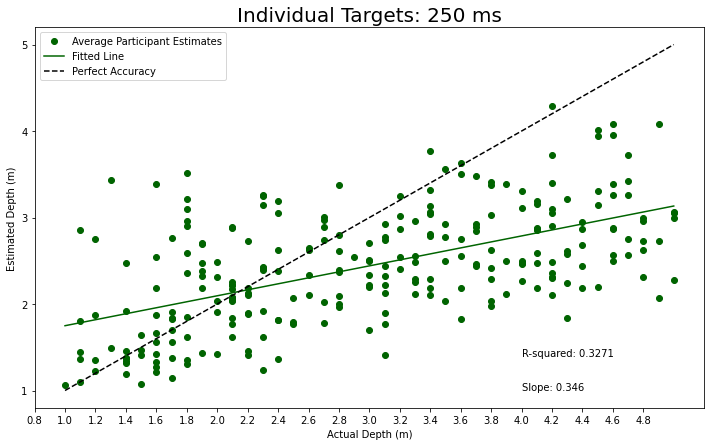

(0.3460021746885778,
 1.4032390164751072,
 0.5719621889376606,
 1.4844407568003107e-23,
 0.031197038097436215)

In [614]:
plot_img(stim_250, final_y_250, ste_250, 250)

slope: 0.021798    intercept: 0.314042
R-squared: 0.023575
Standard-error: 0.008819


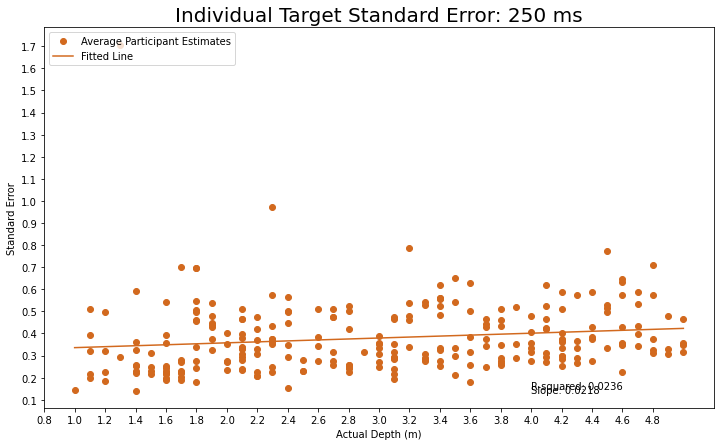

Average Standard Error 250 ms


0.3789047915810963

In [615]:
plot_img_ste(stim_250, final_y_250, ste_250, 250)

avg_250 =np.mean(ste_250)
print("Average Standard Error 250 ms")
avg_250

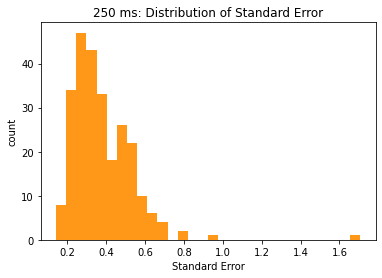

In [616]:
plt.hist(ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

Look at images with standard errors on the tail of the distribution

In [710]:
high_ste_imgs_250 = [final_x_250[idx] for idx in range(len(ste_250)) if ste_250[idx] >= 0.7]
high_ste_imgs_250

['depth_duration_stimuli/003453_10/003453_10-target.png',
 'depth_duration_stimuli/002419_8/002419_8-target.png',
 'depth_duration_stimuli/003576_3/003576_3-target.png',
 'depth_duration_stimuli/003668_6/003668_6-target.png',
 'depth_duration_stimuli/000486_3/000486_3-target.png',
 'depth_duration_stimuli/003185_1/003185_1-target.png']

Notes:
1. Actual Depth = 1.3 m

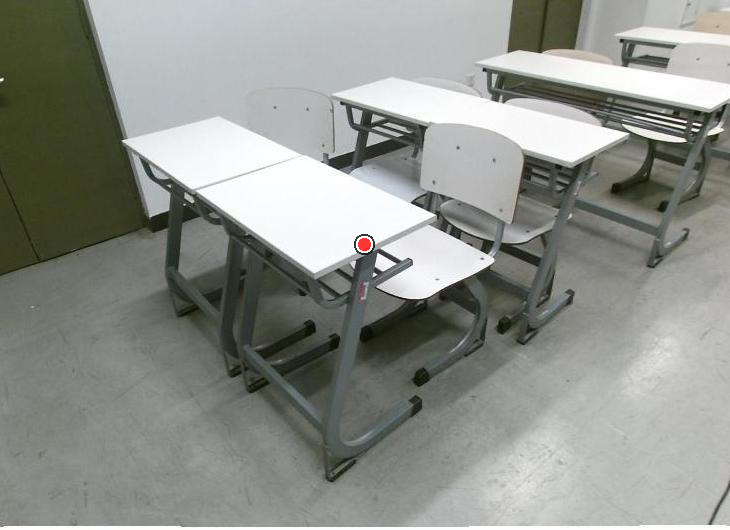

2. Target is on the bottom of the image
3. Actual Depth = 2.1 m

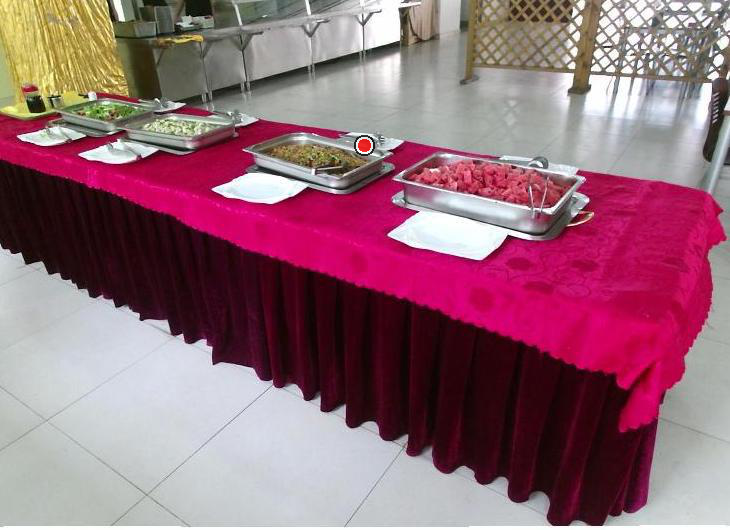

4. Actual Depth = 1.9 m

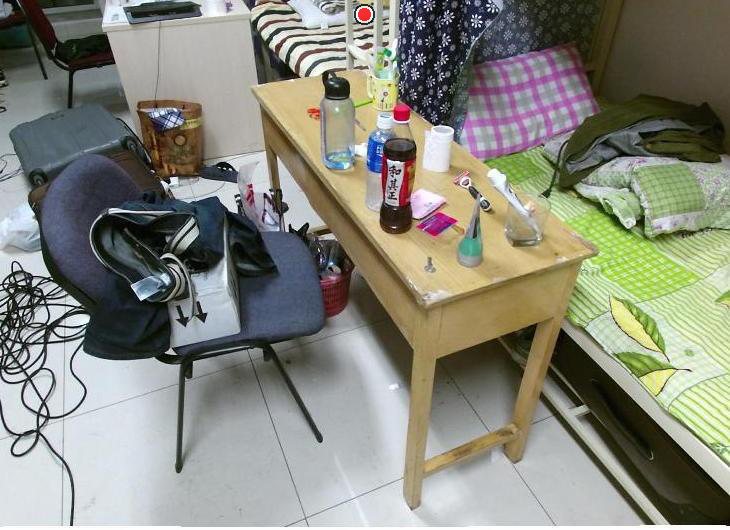

5. Actual Depth = 4.5 m
    - Need to set a threshold for distance from the top of the images
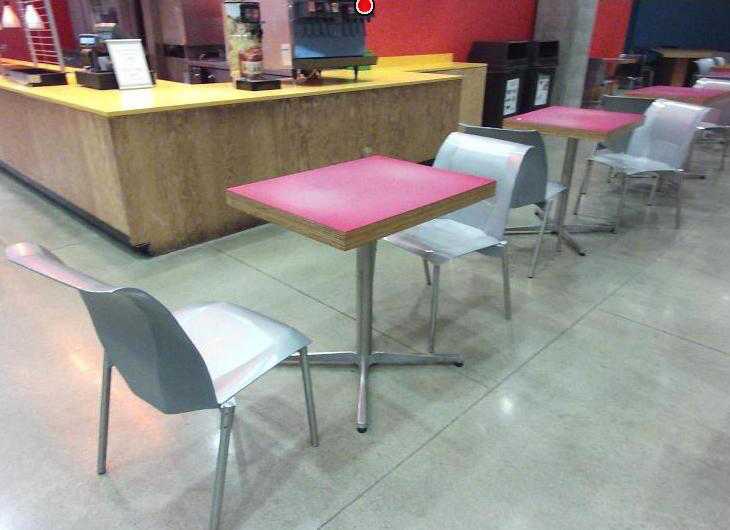

m: [0.43168219]
b: 1.1923283561356943
R-squared:  0.3616191334318639


Text(0, 0.5, 'Residual')

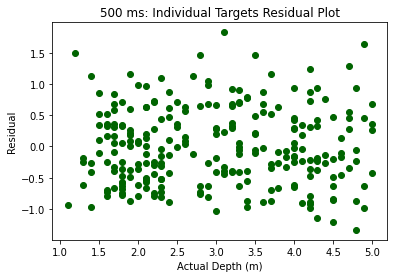

In [1022]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_500).reshape(-1,1)
y = final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

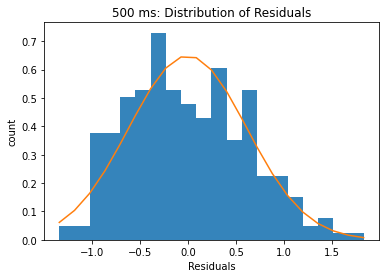

In [1023]:
plt.title('500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')
_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_500, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_500 = scipy.stats.norm.pdf(bins, mu_500, sigma)
plt.plot(bins, best_fit_line_500)

plt.show()

In [619]:
import scipy

scipy.stats.pearsonr(yaw_500, residuals)

(0.11507125012190979, 0.0687556696567117)

slope: 0.431682    intercept: 1.192328
R-squared: 0.361619
Standard-error: 0.036348


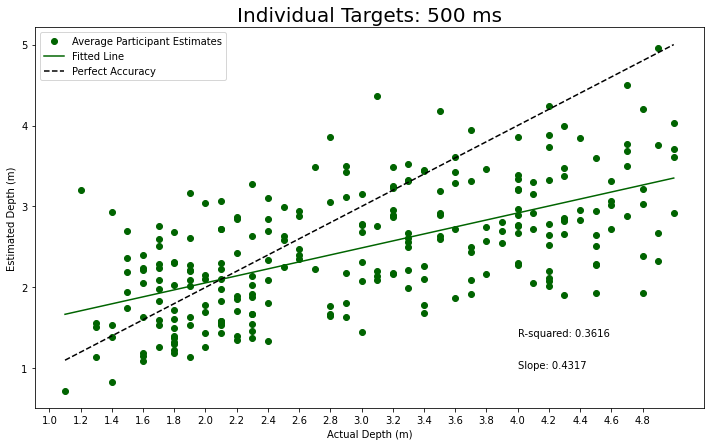

(0.4316821860736691,
 1.1923283561356937,
 0.6013477641364142,
 4.505245249870915e-26,
 0.03634784640272582)

In [620]:
plot_img(stim_500, final_y_500, ste_500, 500)

slope: 0.050391    intercept: 0.228544
R-squared: 0.099442
Standard-error: 0.009610


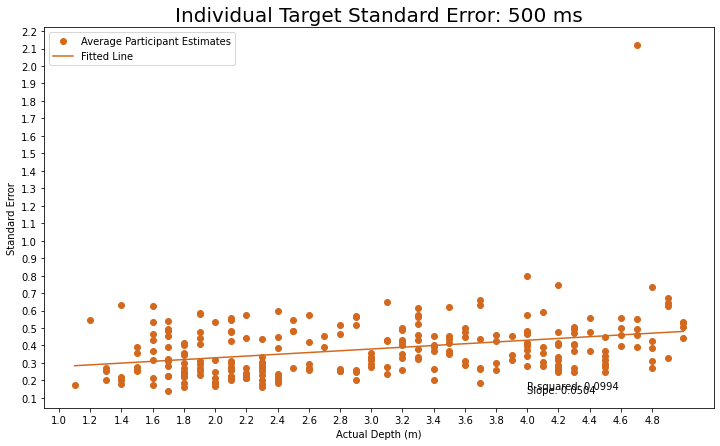

Average Standard Error 500 ms


0.3798381073321194

In [621]:
plot_img_ste(stim_500, final_y_500, ste_500, 500)

avg_500 =np.mean(ste_500)
print("Average Standard Error 500 ms")
avg_500

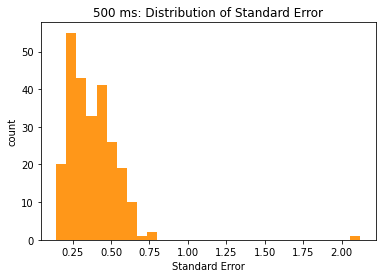

In [622]:
plt.hist(ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

Look at images with standard errors on the tail of the distribution

In [712]:
high_ste_imgs_500 = [final_x_500[idx] for idx in range(len(ste_500)) if ste_500[idx] >= 0.75]
high_ste_imgs_500

['depth_duration_stimuli/003351_1/003351_1-target.png',
 'depth_duration_stimuli/000689_9/000689_9-target.png']

Notes:
1. Actual Depth = ~ 4 m
    - Target is on the ceiling --> object label is probably light which is why it was not filtered out 
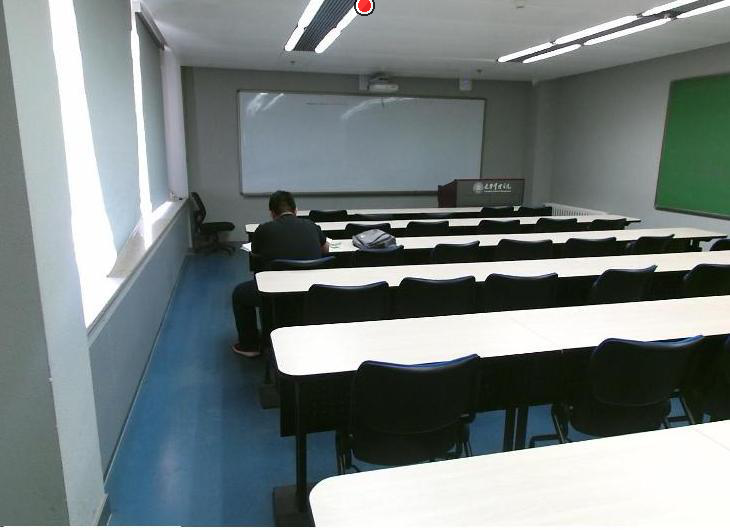

2. Actual Depth = ~ 5 m
    - Confusing target placement?
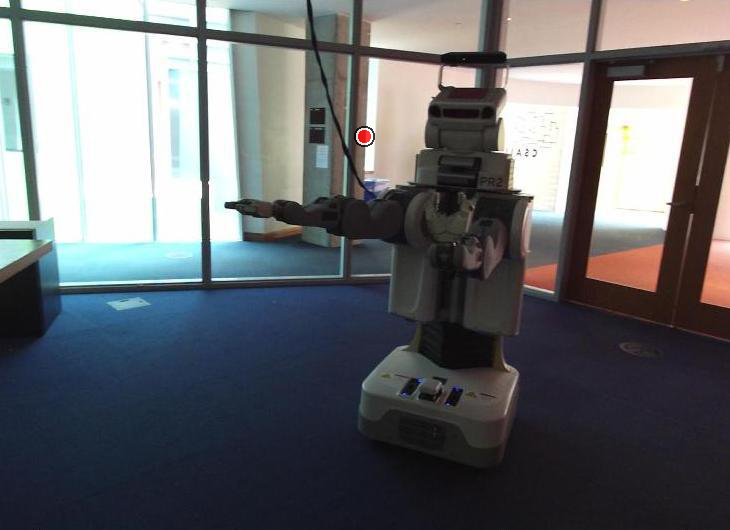

m: [0.52446833]
b: 0.9654614317320795
R-squared:  0.49482204000279184


Text(0, 0.5, 'Residual')

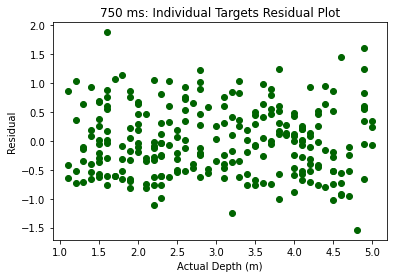

In [1024]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_750).reshape(-1,1)
y = final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

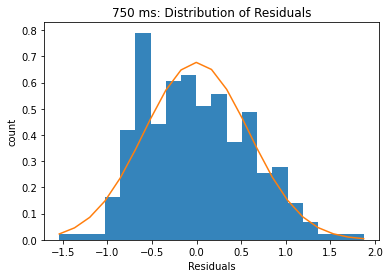

In [1025]:
plt.title('750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_750, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_750 = scipy.stats.norm.pdf(bins, mu_750, sigma)
plt.plot(bins, best_fit_line_750)

plt.show()

In [625]:
import scipy

scipy.stats.pearsonr(yaw_750, residuals)

(0.0878257667048344, 0.1645450952906241)

slope: 0.524468    intercept: 0.965461
R-squared: 0.494822
Standard-error: 0.033516


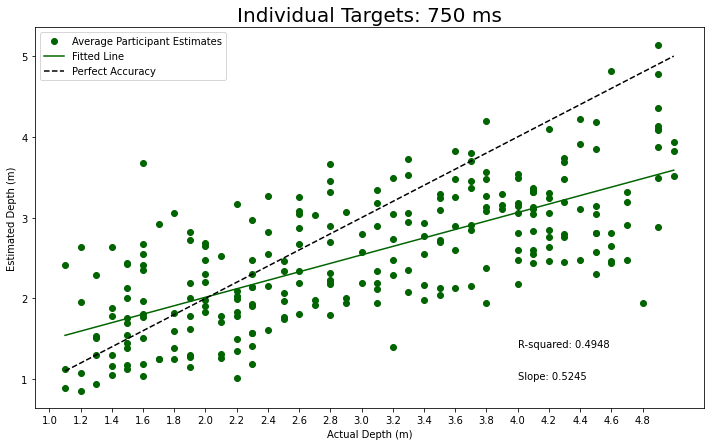

(0.5244683253107941,
 0.9654614317320787,
 0.7034358819414834,
 6.083008920361622e-39,
 0.033515595474380766)

In [626]:
plot_img(stim_750, final_y_750, ste_750, 750)

slope: 0.048813    intercept: 0.226230
R-squared: 0.149474
Standard-error: 0.007364


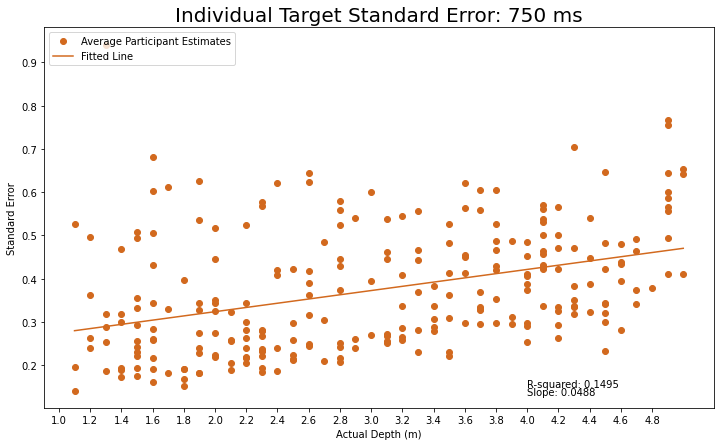

Average Standard Error 750 ms


0.37294099271961073

In [627]:
plot_img_ste(stim_750, final_y_750, ste_750, 750)

avg_750 =np.mean(ste_750)
print("Average Standard Error 750 ms")
avg_750

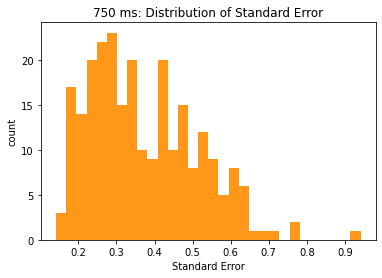

In [628]:
plt.hist(ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

Look at images with standard errors on the tail of the distribution

In [719]:
high_ste_imgs_750 = [final_x_750[idx] for idx in range(len(ste_750)) if ste_750[idx] >= 0.75]
high_ste_imgs_750

['depth_duration_stimuli/003070_6/003070_6-target.png',
 'depth_duration_stimuli/002396_6/002396_6-target.png',
 'depth_duration_stimuli/002396_3/002396_3-target.png']

Notes:
1. Target is on the bottom of the image (tagged depth = 1.3 m)
    - Need to set a threshold for how far target must be from bottom of images
    - Kinectv2 is not accurate at the nearest parts and furthest part of image
2. Actual Depth = 4 m
    - Not sure what is causing the large standard error here
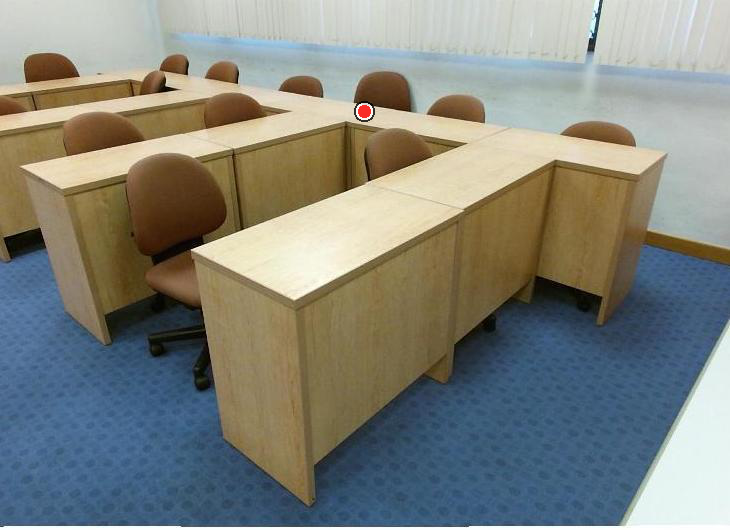

3. Actual Depth = 5m
    - Confusing room boundaires since it is a furniture store 
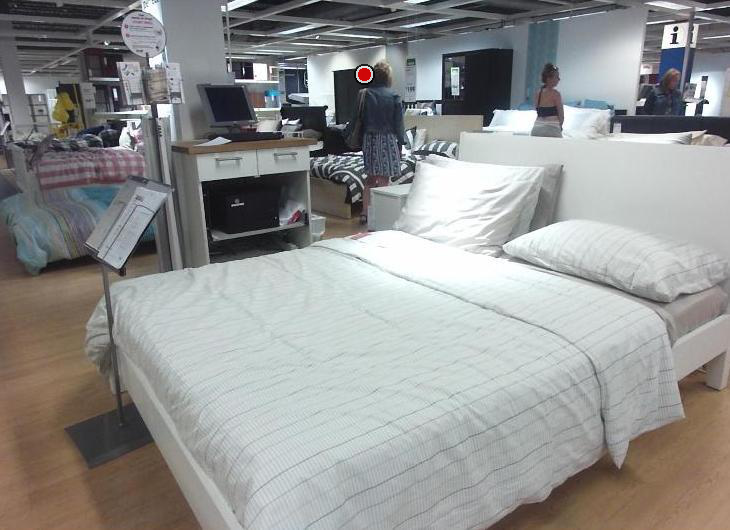

m: [0.52860322]
b: 0.9307801862166636
R-squared:  0.48980436206217637


Text(0, 0.5, 'Residual')

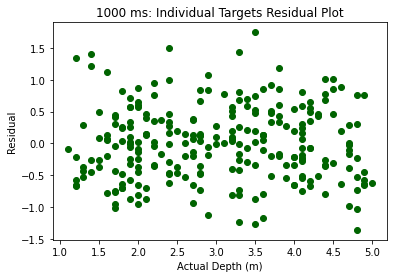

In [1026]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

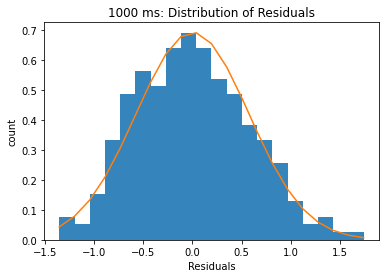

In [1027]:
plt.title('1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

_, bins, _ = plt.hist(residuals, 20, density=1, alpha=0.9)
mu_1000, sigma = scipy.stats.norm.fit(residuals)
best_fit_line_1000 = scipy.stats.norm.pdf(bins, mu_1000, sigma)
plt.plot(bins, best_fit_line_1000)

plt.show()

In [631]:
import scipy

scipy.stats.pearsonr(yaw_1000, residuals)

(-0.041146087202661816, 0.5155617893937503)

slope: 0.528603    intercept: 0.930780
R-squared: 0.489804
Standard-error: 0.034121


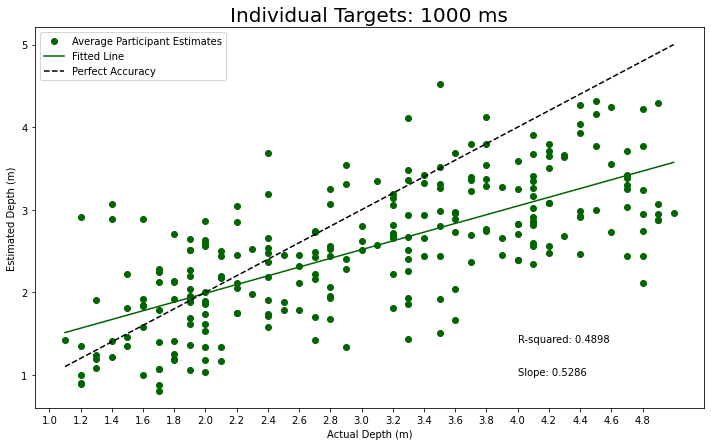

(0.5286032237949546,
 0.9307801862166656,
 0.6998602446647297,
 2.1030033488363463e-38,
 0.034120614922279906)

In [632]:
plot_img(stim_1000, final_y_1000, ste_1000, 1000)

slope: 0.040796    intercept: 0.254615
R-squared: 0.100637
Standard-error: 0.007713


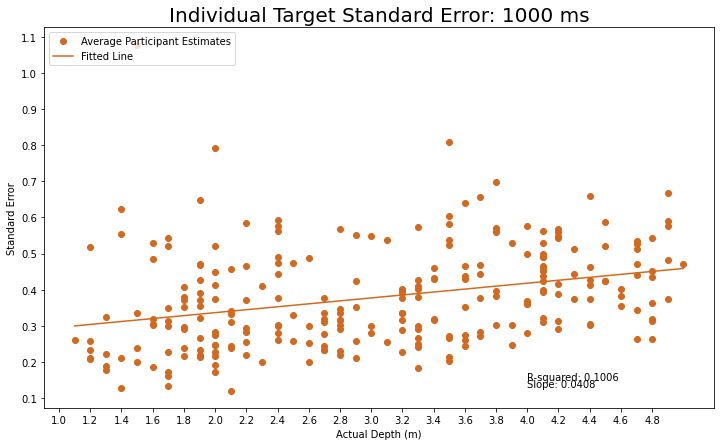

Average Standard Error 1000 ms


0.37810221218891504

In [633]:
plot_img_ste(stim_1000, final_y_1000, ste_1000, 1000)

avg_1000 =np.mean(ste_1000)
print("Average Standard Error 1000 ms")
avg_1000

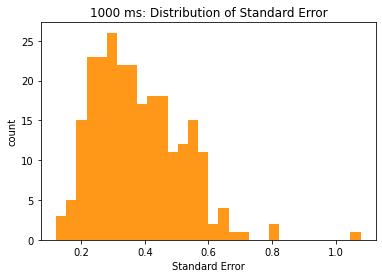

In [634]:
plt.hist(ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

Look at images with standard errors on the tail of the distribution

In [718]:
high_ste_imgs_1000 = [final_x_1000[idx] for idx in range(len(ste_1000)) if ste_1000[idx] >= 0.7]
high_ste_imgs_1000

['depth_duration_stimuli/001479_8/001479_8-target.png',
 'depth_duration_stimuli/002120_16/002120_16-target.png',
 'depth_duration_stimuli/000739_4/000739_4-target.png']

#### Summary Plots

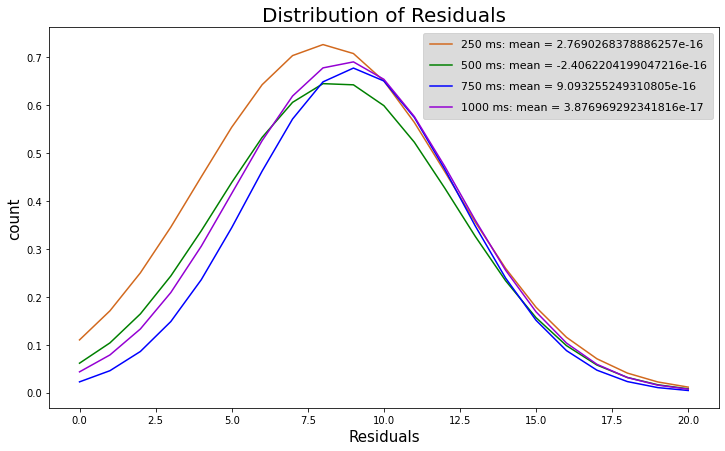

In [1043]:
plt.figure(figsize = [12, 7])
plt.title('Distribution of Residuals', fontsize = 20)
plt.xlabel('Residuals', fontsize = 15)
plt.ylabel('count', fontsize = 15)

plt.plot(best_fit_line_250, color = 'chocolate', label = '250 ms: '
        + 'mean = ' + str(mu_250))
plt.plot(best_fit_line_500, color = 'green', label = '500 ms: '
        + 'mean = ' + str(mu_500))
plt.plot(best_fit_line_750, color = 'blue', label = '750 ms: '
        + 'mean = ' + str(mu_750))
plt.plot(best_fit_line_1000, color = 'darkviolet', label = '1000 ms: '
        + 'mean = ' + str(mu_1000))

legend = plt.legend(loc = 0, fontsize = 11, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')


Notes:
1. Target is on the bottom of the image (tagged as 1.4 m by Kinectv2)
    - should we exclude targets that are on the bottom of the images?
2. Actual depth = 1.9 m

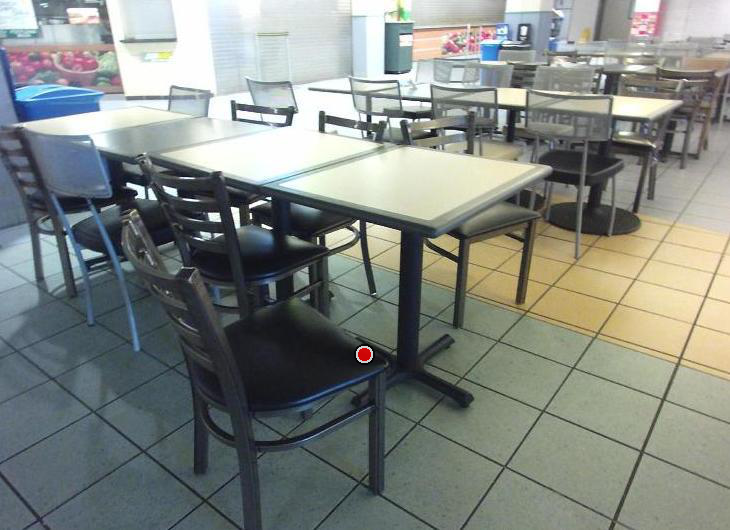.png](attachment:fbc11ffd-a094-45ca-b167-8d8983ad8bc4.png)

3. Actual depth = 3.5 m
Should the target diameter be reduced?

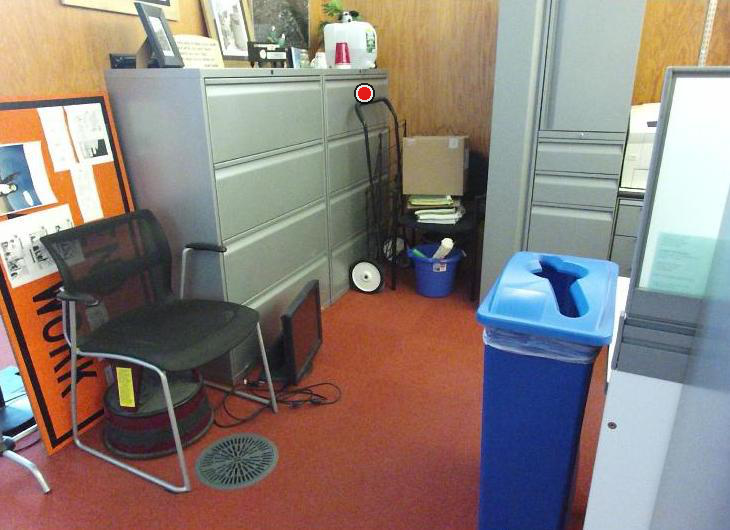
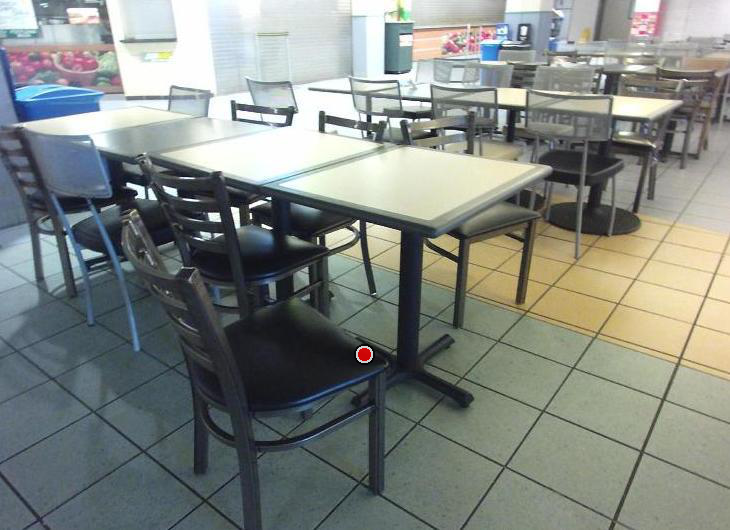

#### Sum of Abs Value of Individual Target Residuals from Identity Line (Perfect Accuracy) for each Duration Divided by the Number of Images

In [760]:
y_250_target_avgs = np.array(final_y_250)
perfect_accuracy_250 = np.array(stim_250)

#.reshape(-1,1)

residuals_250 = y_250_target_avgs - perfect_accuracy_250
abs_residuals_250 = np.absolute(residuals_250)
sum_residuals_250 = np.sum(abs_residuals_250)
(sum_residuals_250/len(stim_250)) 

0.8294219905854117

In [761]:
y_500_target_avgs = np.array(final_y_500)
perfect_accuracy_500 = np.array(stim_500)

#.reshape(-1,1)

residuals_500 = y_500_target_avgs - perfect_accuracy_500
abs_residuals_500 = np.absolute(residuals_500)
sum_residuals_500 = np.sum(abs_residuals_500)
(sum_residuals_500/len(stim_500)) 

0.8034776898821746

In [762]:
y_750_target_avgs = np.array(final_y_750)
perfect_accuracy_750 = np.array(stim_750)

#.reshape(-1,1)

residuals_750 = y_750_target_avgs - perfect_accuracy_750
abs_residuals_750 = np.absolute(residuals_750)
sum_residuals_750 = np.sum(abs_residuals_750)
(sum_residuals_750/len(stim_750)) 

0.7385407090912369

In [763]:
y_1000_target_avgs = np.array(final_y_1000)
perfect_accuracy_1000 = np.array(stim_1000)

#.reshape(-1,1)

residuals_1000 = y_1000_target_avgs - perfect_accuracy_1000
abs_residuals_1000 = np.absolute(residuals_1000)
sum_residuals_1000 = np.sum(abs_residuals_1000)
(sum_residuals_1000/len(stim_1000)) 

0.7192831202840149

#### Normalized data

In [770]:
## Execute this cell to prep for plotting
##############################
# Set to the appropriate var
normalized_trial_plot_data = trial_normalized_final
avg_average_particip_estim = 2.4779054712373956 # calculated above
##############################

n_final_x_250 = normalized_trial_plot_data[0][0]
n_final_y_250 = normalized_trial_plot_data[1][0]
n_ste_250 = normalized_trial_plot_data[2][0]
n_stim_250 = normalized_trial_plot_data[3][0]

n_final_x_500 = normalized_trial_plot_data[0][1]
n_final_y_500 = normalized_trial_plot_data[1][1]
n_ste_500 = normalized_trial_plot_data[2][1]
n_stim_500 = normalized_trial_plot_data[3][1]

n_final_x_750 = normalized_trial_plot_data[0][2]
n_final_y_750 = normalized_trial_plot_data[1][2]
n_ste_750 = normalized_trial_plot_data[2][2]
n_stim_750 = normalized_trial_plot_data[3][2]

n_final_x_1000 = normalized_trial_plot_data[0][3]
n_final_y_1000 = normalized_trial_plot_data[1][3]
n_ste_1000 = normalized_trial_plot_data[2][3]
n_stim_1000 = normalized_trial_plot_data[3][3]

In [771]:
kinectv2_path = '/Users/prachi/Documents/depth_duration/SUNRGBD/kv2/kinect2data'

# line comprehension for x(stim path) in final_x --> calculate tilt 

n_yaw_250 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_250]
n_yaw_500 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_500]
n_yaw_750 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_750]
n_yaw_1000 = [calculate_yaw(path, kinectv2_path) for path in n_final_x_1000]

In [772]:
def normalized_plot_img(actualdepth, y, ste, duration, avg):
    """
    Calculate a linear least-squares regression for two sets of measurements.
    
    Args: 
        data = List of arrays x, y
        duration = integer value of duration (e.g. 250)
        
    Returns: Matplotlib plot 
        slope: Slope of the regression line.
        intercept: Intercept of the regression line.
        rvalue: Correlation coefficient.
        pvalue: Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.
        stderr: Standard error of the estimated gradient.
    """
    x = np.array(actualdepth)
    y = np.array(y)
    ste = np.array(ste)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    print("Standard-error: %f" % std_err)
    plt.figure(figsize = [12, 7])
    text_slope = 'Slope: ' + str(round(slope, 4))
    plt.text(4, 0.5, text_slope)
    text_r2 = 'R-squared: ' + str(round(r_value**2, 4))
    plt.text(4, 0.7, text_r2) 
    
    plt.xticks(np.arange(0, 5, step=0.2))
    plt.yticks(np.arange(0, 10, step = 1))
    plt.title(label = "Individual Targets: " + str(duration) + " ms", size = "20")
    plt.xlabel("Actual Depth (m)")
    plt.ylabel("Estimated Depth (m)")
    plt.plot(x, y, 'o', label='Average Participant Estimates', color = "darkgreen")
    plt.plot(x, intercept + slope*x, 'r', label='Fitted Line', color = "darkgreen")
#     plt.errorbar(x, y, yerr=ste, ecolor = "blue", fmt = 'or', mfc = "blue", mec = "blue")
    # Perfect accuracy line
    plt.plot(x, x/avg, label = "Perfect Accuracy Normalized", color = 'black',linestyle='--')  # solid
    plt.legend(loc='upper left')
    plt.show()
    
    return slope, intercept, r_value, p_value, std_err

m: [0.14195391]
b: 0.545439868423234
R-squared:  0.42702148884339397


Text(0, 0.5, 'Residual')

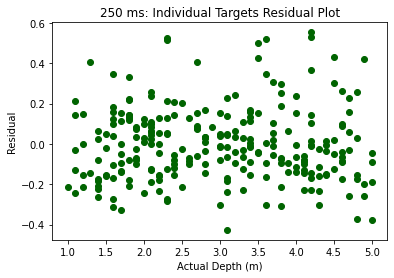

In [773]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_250).reshape(-1,1)
y = n_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

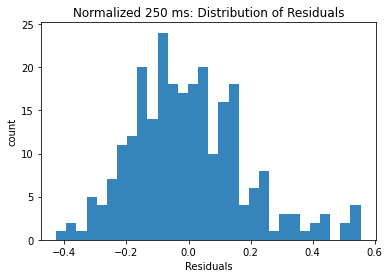

In [774]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 250 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [775]:
import scipy

scipy.stats.pearsonr(n_yaw_250, residuals)

(0.013749745780135198, 0.8270415655140378)

slope: 0.141954    intercept: 0.545440
R-squared: 0.427021
Standard-error: 0.010338


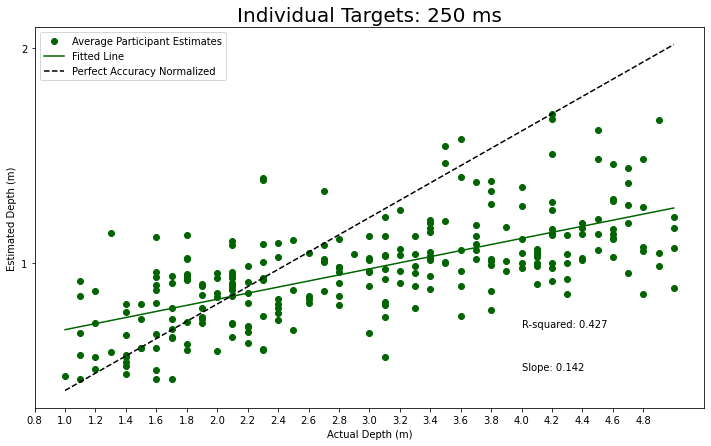

In [776]:
slope_250 = normalized_plot_img(n_stim_250, n_final_y_250, n_ste_250, 250,
                                       avg_average_particip_estim)[0]

slope: 0.004544    intercept: 0.080984
R-squared: 0.007718
Standard-error: 0.003240


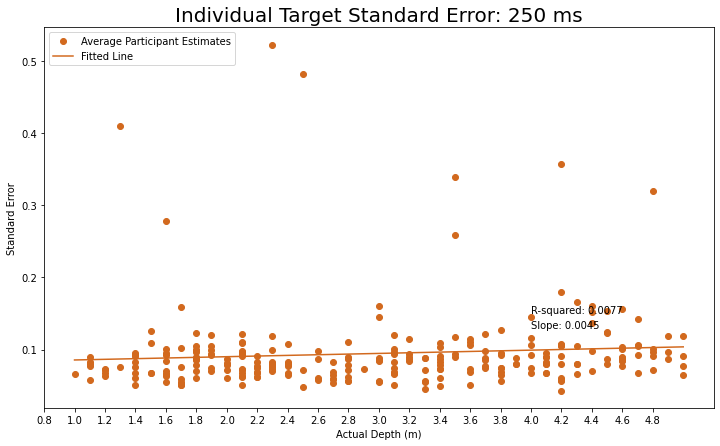

Normalized: Average Standard Error 250 ms


0.09450682049655054

In [777]:
slope_250 = plot_img_ste(n_stim_250, n_final_y_250, n_ste_250, 250)[0]

avg_250 =np.mean(n_ste_250)
print("Normalized: Average Standard Error 250 ms")
avg_250

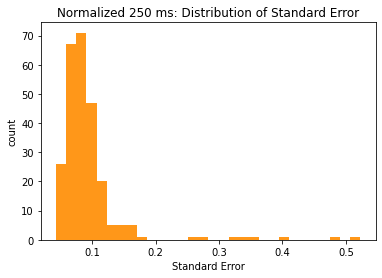

In [778]:
plt.hist(n_ste_250, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 250 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

m: [0.17760956]
b: 0.46267166282027594
R-squared:  0.4182753667821384


Text(0, 0.5, 'Residual')

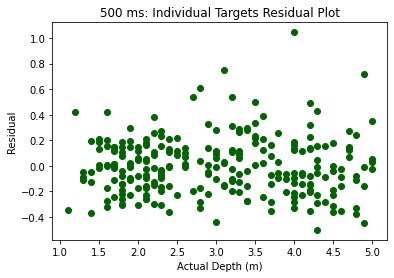

In [779]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_500).reshape(-1,1)
y = n_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

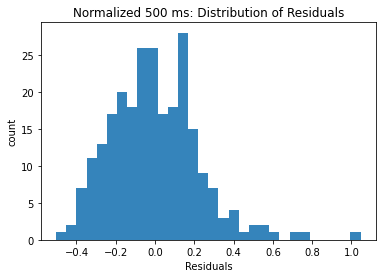

In [780]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 500 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [781]:
import scipy

scipy.stats.pearsonr(n_yaw_500, residuals)

(0.060919627445499405, 0.3364395878061795)

slope: 0.177610    intercept: 0.462672
R-squared: 0.418275
Standard-error: 0.013274


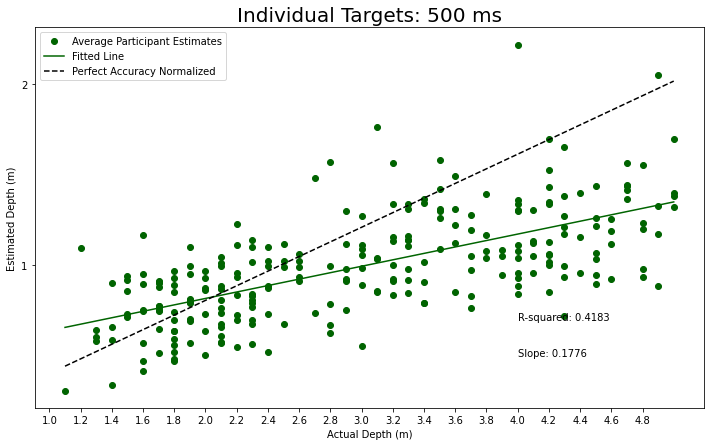

In [782]:
slope_500 = normalized_plot_img(n_stim_500, n_final_y_500, n_ste_500, 500,
                                       avg_average_particip_estim)[0]


slope: 0.013606    intercept: 0.050842
R-squared: 0.084614
Standard-error: 0.002836


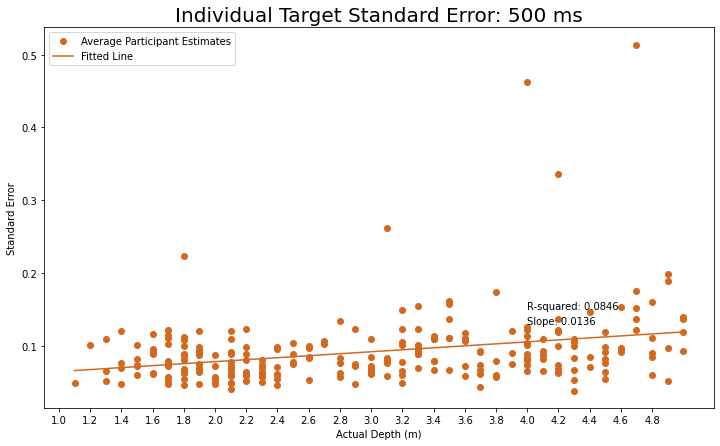

Normalized: Average Standard Error 500 ms


0.09169162670688313

In [783]:
slope_500 = plot_img_ste(n_stim_500, n_final_y_500, n_ste_500, 500)[0]

avg_500 =np.mean(n_ste_500)
print("Normalized: Average Standard Error 500 ms")
avg_500

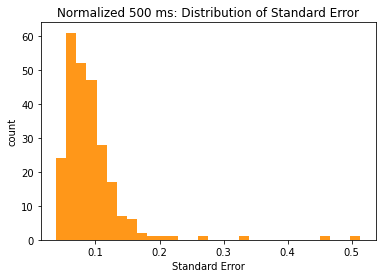

In [784]:
plt.hist(n_ste_500, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 500 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

m: [0.21430492]
b: 0.3775883232696592
R-squared:  0.5540344631882208


Text(0, 0.5, 'Residual')

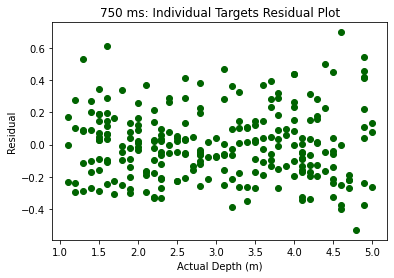

In [786]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(n_stim_750).reshape(-1,1)
y = n_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

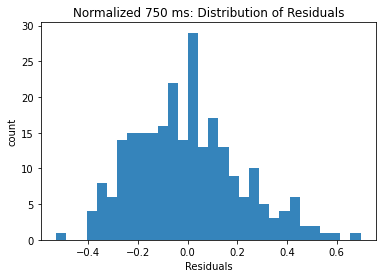

In [787]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 750 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [788]:
import scipy

scipy.stats.pearsonr(n_yaw_750, residuals)

(0.04929747760710292, 0.43588760792695036)

slope: 0.214305    intercept: 0.377588
R-squared: 0.554034
Standard-error: 0.012160


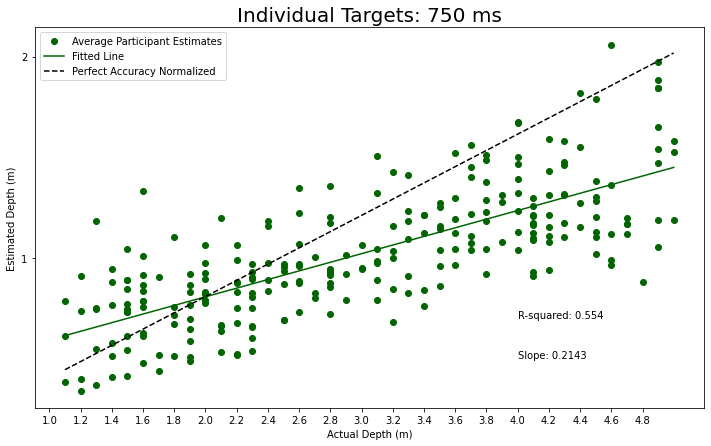

In [789]:
slope_750 = normalized_plot_img(n_stim_750, n_final_y_750, n_ste_750, 750,
                                       avg_average_particip_estim)[0]


slope: 0.011756    intercept: 0.057086
R-squared: 0.077240
Standard-error: 0.002570


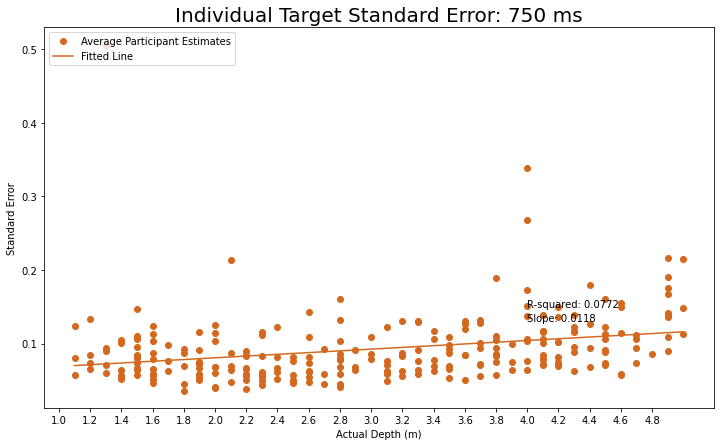

Normalized: Average Standard Error 750 ms


0.09241842558201646

In [790]:
slope_750 = plot_img_ste(n_stim_750, n_final_y_750, n_ste_750, 750)[0]

avg_750 =np.mean(n_ste_750)
print("Normalized: Average Standard Error 750 ms")
avg_750

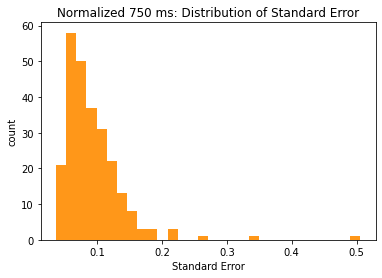

In [791]:
plt.hist(n_ste_750, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 750 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

m: [0.52860322]
b: 0.9307801862166636
R-squared:  0.48980436206217637


Text(0, 0.5, 'Residual')

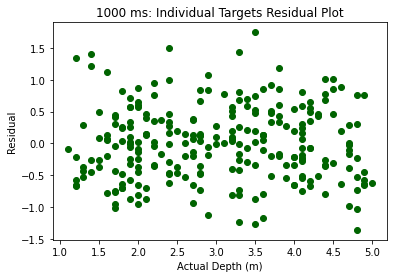

In [793]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(stim_1000).reshape(-1,1)
y = final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)
#Plot Our Actual and Predicted Values
# plt.plot(X, y, 'o', color='black');
# plt.plot(X,y_predicted,color='darkgreen')
# plt.title("250 ms: Actuals vs Regression Line")
# plt.xlabel("Actual Depth (m)")
# plt.ylabel("Estimated Depth (m)")
# plt.plot(X, X/avg_average_particip_estim, label = "Perfect Accuracy", color = 'black',linestyle='--')  # solid


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

residuals = y-y_predicted
plt.plot(X,residuals, 'o', color='darkgreen')
plt.title("1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

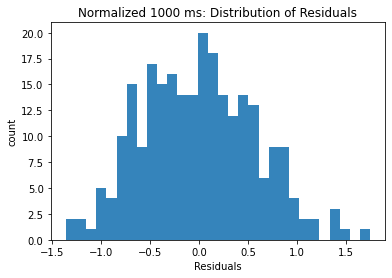

In [794]:
plt.hist(residuals, bins=30, alpha=0.9)
plt.title('Normalized 1000 ms: Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('count')

plt.show()

In [795]:
import scipy

scipy.stats.pearsonr(n_yaw_1000, residuals)

(-0.041146087202661816, 0.5155617893937503)

slope: 0.222830    intercept: 0.338165
R-squared: 0.550703
Standard-error: 0.012730


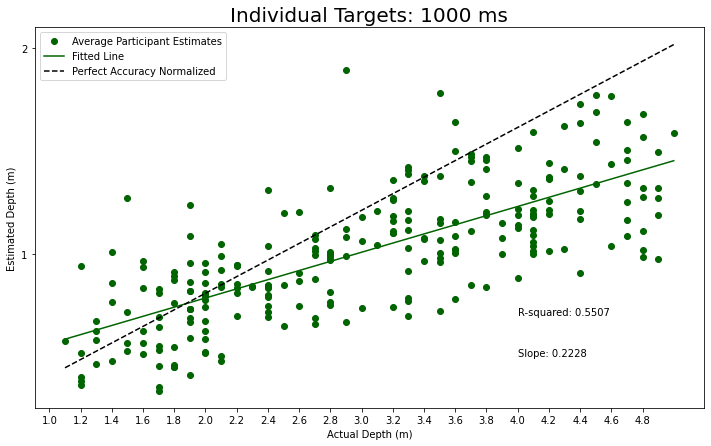

In [796]:
slope_1000 = normalized_plot_img(n_stim_1000, n_final_y_1000, n_ste_1000, 1000,
                                       avg_average_particip_estim)[0]

slope: 0.009604    intercept: 0.062872
R-squared: 0.038974
Standard-error: 0.003016


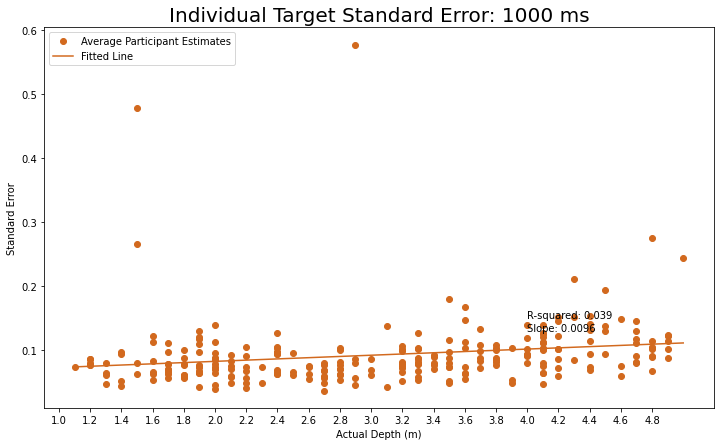

Normalized: Average Standard Error 1000 ms


0.09194229651912776

In [797]:
slope_1000 = plot_img_ste(n_stim_1000, n_final_y_1000, n_ste_1000, 1000)[0]

avg_100 =np.mean(n_ste_1000)
print("Normalized: Average Standard Error 1000 ms")
avg_100

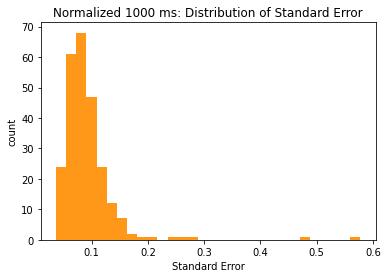

In [798]:
plt.hist(n_ste_1000, bins=30, alpha=0.9, color = 'darkorange')
plt.title('Normalized 1000 ms: Distribution of Standard Error')
plt.xlabel('Standard Error')
plt.ylabel('count')

plt.show()

In [769]:
avg_average_particip_estim

2.4779054712373956

#### Sum of Abs Value of Individual Target Residuals from Identity Line (Perfect Accuracy) for each Duration Divided by the Number of Images, Multiplied by Avg Depth Estimation

In [765]:
n_y_250_target_avgs = np.array(n_final_y_250)
n_perfect_accuracy_250 = np.array(n_stim_250)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_250 = n_y_250_target_avgs - n_perfect_accuracy_250
n_abs_residuals_250 = np.absolute(n_residuals_250)
n_sum_residuals_250 = np.sum(n_abs_residuals_250)
avg_average_particip_estim * (n_sum_residuals_250/len(n_stim_250))

0.8059772371117145

In [766]:
n_y_500_target_avgs = np.array(n_final_y_500)
n_perfect_accuracy_500 = np.array(n_stim_500)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_500 = n_y_500_target_avgs - n_perfect_accuracy_500
n_abs_residuals_500 = np.absolute(n_residuals_500)
n_sum_residuals_500 = np.sum(n_abs_residuals_500)
avg_average_particip_estim * (n_sum_residuals_500/len(n_stim_500))

0.7708876596510049

In [767]:
n_y_750_target_avgs = np.array(n_final_y_750)
n_perfect_accuracy_750 = np.array(n_stim_750)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_750 = n_y_750_target_avgs - n_perfect_accuracy_750
n_abs_residuals_750 = np.absolute(n_residuals_750)
n_sum_residuals_750 = np.sum(n_abs_residuals_750)
avg_average_particip_estim * (n_sum_residuals_750/len(n_stim_750))

0.7033848187286228

In [768]:
n_y_1000_target_avgs = np.array(n_final_y_1000)
n_perfect_accuracy_1000 = np.array(n_stim_1000)/avg_average_particip_estim

#.reshape(-1,1)

n_residuals_1000 = n_y_1000_target_avgs - n_perfect_accuracy_1000
n_abs_residuals_1000 = np.absolute(n_residuals_1000)
n_sum_residuals_1000 = np.sum(n_abs_residuals_1000)
avg_average_particip_estim * (n_sum_residuals_1000/len(n_stim_1000))

0.6913777951075661

## Split data randomly into half: Correlate Residuals

In [104]:
import random

def get_stimuli(data):
    """
    Args:
        data = [df_250, df_500, df_750, df_1000]
    Returns:
        all_stimuli = [imgs_250, imgs_500, imgs_750, imgs_1000]
    """
    
    all_stimuli = []
    for df in data:
        stimuli = set()
        for idx, row in df.iterrows():
            stimulus = row["stimulus"]
            stimuli.add(stimulus)
        all_stimuli.append(list(stimuli))
        
    return all_stimuli

def data_split(data):
    """
    Args:
        Data post outlier removal: i.e. raw_postOutlier_data --> list of duration dfs 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
        Splits the data for a given target (stimulus) into two dfs  
    """
    
    stimuli = get_stimuli(raw_postOutlier_data)
    
    duration_dfs_split = [[None, None, None, None], [None, None, None, None]]
    for i in range(4):
        split1 = [] 
        split2 = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            # create random assignment of df1 and df2 in a 50/50 split 
            random_assignment = [0,1] * (stim_df.shape[0]//2)
            random.shuffle(random_assignment)
            print(random_assignment)
            df0 = pd.concat([pd.DataFrame([stim_df.iloc[idx]]) for i in range(len(random_assignment)) if random_assignment[i] == 0])
            df1 = pd.concat([pd.DataFrame([stim_df.iloc[idx]]) for i in range(len(random_assignment)) if random_assignment[i] == 1])
            return stim_df, df0, df1
            
#             # add df for this stimulus to list of stimulus data dfs for the duration (i) 
#             split1.append(df1) 
#             split2.append(df2)
        
#         # concatenate all stimulis dfs in each split, and add to main 2D list of duration dfs for each split
#         duration_dfs_split[0][i] = pd.concat(split1)
#         duration_dfs_split[1][i] = pd.concat(split2)
#     return duration_dfs_split

# NOTE: Since targets have an odd number of datapoints, split1 ends up being smaller than split2
        
def data_split_variable_size(data, fraction):
    """
    Args:
        Data post outlier removal: i.e. raw_postOutlier_data --> list of duration dfs 
        fraction: percentage of data to be used in each split 
    Returns:
        [[250, 500, 750, 1000], [250, 500, 750, 1000]]
    
    Used for power analysis 
    Splits the data for a given target (stimulus) into two dfs (size determined by 'fraction')
    """
    
    stimuli = get_stimuli(raw_postOutlier_data)
    
    duration_dfs_split = [[None, None, None, None], [None, None, None, None]]
    for i in range(4):
        split1 = [] 
        split2 = []
        duration_df = data[i]
        duration_stim = stimuli[i]
        
        grouped = duration_df.groupby(duration_df.stimulus) 
        for stim in duration_stim:   
            stim_df = grouped.get_group(stim)
            random_assignment = [0,1] * (stim_df.shape[0]//2)
            random.shuffle(random_assignment)
            df1 = stim_df.sample(frac=fraction,random_state=np.random.RandomState()) # randomly sample have the datapoints 
            # sample datapoints not sampled in df1 so that entire dataspace is covered 
            lst = [] # list of rows in stim_df not in df1
            for idx, row in stim_df.iterrows():
                ## CHECK THAT THE TWO DFs ARE DIFFERENT!!!!!! 
                if row['subjID'] not in df1.values:
                    lst.append(row)
            not_df1 = pd.DataFrame(lst)
            # randomly sample the same number of samples selected in df1 
            df2 = not_df1.sample(n=df1.shape[0],random_state=np.random.RandomState()) # randomly sample have the datapoints 
            
            # add df for this stimulus to list of stimulus data dfs for the duration (i) 
            split1.append(df1) 
            split2.append(df2)
        
        # concatenate all stimulis dfs in each split, and add to main 2D list of duration dfs for each split
        duration_dfs_split[0][i] = pd.concat(split1)
        duration_dfs_split[1][i] = pd.concat(split2)
    return duration_dfs_split
        

In [106]:
s = data_split(raw_postOutlier_data)
s[0]

[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]


subjID experimentName            versionName sequenceName  \
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
15063  261659.0    DepthScenes  duration_manipulation  sequence_N4   
16599  974367.0    DepthScenes  duration_manipulation  sequence_N4   
16855  652326.0    DepthScenes  duration_manipulation  sequence_N4   
25559  109113.0    DepthScenes  duration_manipulation  sequence_N4   
17879  840764.0    DepthScenes  duration_manipulation  sequence_N4   
17367  983103.0    DepthScenes  duration_manipulation  sequence_N4   
24535  977559.0    DepthScenes  duration_manipulation  sequence_N4   
14551  849578.0    DepthScenes  duration_manipulation  sequence_N4   
17111  198373.0    DepthScenes  duration_manipulation  sequence_N4   
15575  345861.0    DepthScenes  duration_manipulation  sequence_N4   
16343  742663.0    DepthScenes  duration_manipulation  sequence_N4   
25047  805124.0    DepthScenes  duration_manipulation  sequence_N4   
18135  208662.0    DepthScenes  duration_manipulation  sequence_N4   
14807  738594.0    DepthScenes  duration_manipulation  sequence_N4   
17623  303421.0    DepthScenes  duration_manipulation  sequence_N4   
16087  352586.0    DepthScenes  duration_manipulation  sequence_N4   
15319  580436.0    DepthScenes  duration_manipulation  sequence_N4   
18647  193532.0    DepthScenes  duration_manipulation  sequence_N4   

                                                     url  selected_row  \
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
15063  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
16599  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
16855  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
25559  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
17879  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
17367  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
24535  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
14551  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
17111  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
15575  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
16343  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
25047  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
18135  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
14807  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
17623  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
16087  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
15319  http://100.26.60.149/DepthDuration/depth_durat...           4.0   
18647  http://100.26.60.149/DepthDuration/depth_durat...           4.0   

       windowWidth  windowHeight  screenWidth  screenHeight  ...  trial  \
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
15063       1366.0         625.0       1366.0         768.0  ...  216.0   
16599       1366.0         625.0       1366.0         768.0  ...  216.0   
16855       1366.0         625.0       1366.0         768.0  ...  216.0   
25559       1360.0         667.0       1360.0         768.0  ...  216.0   
17879       1366.0         625.0       1366.0         768.0  ...  216.0   
17367       1366.0         625.0       1366.0         768.0  ...  216.0   
24535       1366.0         657.0       1366.0         768.0  ...  216.0   
14551       1366.0         625.0       1366.0         768.0  ...  216.0   
17111       1366.0         657.0       1366.0         768.0  ...  216.0   
15575       1360.0         667.0       1360.0         768.0  ...  216.0   
16343   

In [102]:
s[1]

subjID experimentName            versionName sequenceName  \
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   
24023  454165.0    DepthScenes  duration_manipulation  sequence_N4   

                                                     url  selected_row  \
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
24023  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   

       windowWidth  windowHeight  screenWidth  screenHeight  ...  trial  \
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   
24023       1881.0         928.0       1920.0        1080.0  ...  216.0   

                                                stimulus  duration  \
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
24023  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   

      actual_depth  depth_estimate  trial_RT  log_sceneDuration  \
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   
24023          4.0          2.4384    3348.0              237.0   

       unitSelection  experimentTime  totalTime  
24023         meters       1189408.0  

In [103]:
s[2]

subjID experimentName            versionName sequenceName  \
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   
25303  703001.0    DepthScenes  duration_manipulation  sequence_N4   

                                                     url  selected_row  \
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   
25303  http://3.84.2.3/DepthDuration/depth_duration_M...           4.0   

       windowWidth  windowHeight  screenWidth  screenHeight  ...  trial  \
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   
25303       1280.0         611.0       1280.0         720.0  ...  216.0   

                                                stimulus  duration  \
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   
25303  depth_duration_stimuli/001907_11/001907_11-tar...     250.0   

      actual_depth  depth_estimate  trial_RT  log_sceneDuration  \
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   
25303          4.0             3.0    1682.0              250.0   

       unitSelection  experimentTime totalTime  
25303         meters        841987.0  8

In [868]:
from sklearn.linear_model import LinearRegression
import scipy

def split_residual_regression(post_outlier_data):
#     split = data_split(post_outlier_data)
    split = data_split_variable_size(post_outlier_data, 0.4)
    
    split1_pivot = trial_pivotTable(split[0])
    split2_pivot = trial_pivotTable(split[1])
    
    split1_final = trial_getxy(split1_pivot)
    split2_final =trial_getxy(split2_pivot)
    
    ############### Split 1 ################
    split1_final_x_250 = split1_final[0][0]
    split1_final_y_250 = split1_final[1][0]
    split1_ste_250 = split1_final[2][0]
    split1_stim_250 = split1_final[3][0]

    split1_final_x_500 = split1_final[0][1]
    split1_final_y_500 = split1_final[1][1]
    split1_ste_500 = split1_final[2][1]
    split1_stim_500 = split1_final[3][1]

    split1_final_x_750 = split1_final[0][2]
    split1_final_y_750 = split1_final[1][2]
    split1_ste_750 = split1_final[2][2]
    split1_stim_750 = split1_final[3][2]

    split1_final_x_1000 = split1_final[0][3]
    split1_final_y_1000 = split1_final[1][3]
    split1_ste_1000 = split1_final[2][3]
    split1_stim_1000 = split1_final[3][3]
    
    ############### Split 2 ################
    split2_final_x_250 = split2_final[0][0]
    split2_final_y_250 = split2_final[1][0]
    split2_ste_250 = split2_final[2][0]
    split2_stim_250 = split2_final[3][0]

    split2_final_x_500 = split2_final[0][1]
    split2_final_y_500 = split2_final[1][1]
    split2_ste_500 = split2_final[2][1]
    split2_stim_500 = split2_final[3][1]

    split2_final_x_750 = split2_final[0][2]
    split2_final_y_750 = split2_final[1][2]
    split2_ste_750 = split2_final[2][2]
    split2_stim_750 = split2_final[3][2]

    split2_final_x_1000 = split2_final[0][3]
    split2_final_y_1000 = split2_final[1][3]
    split2_ste_1000 = split2_final[2][3]
    split2_stim_1000 = split2_final[3][3]
    
    ############ 250 ms: Split 1 #############
    #run regression
    X_s1_250 = np.array(split1_stim_250).reshape(-1,1)
    y_s1_250 = split1_final_y_250
    reg_s1_250 = LinearRegression().fit(X_s1_250, y_s1_250)

    #Generated Predictions
    y_predicted_s1_250 = reg_s1_250.predict(X_s1_250)

    split1_250_residuals = y_s1_250-y_predicted_s1_250

    ############ 250 ms: Split 2 #############
    #run regression
    X_s2_250 = np.array(split2_stim_250).reshape(-1,1)
    y_s2_250 = split2_final_y_250
    reg_s2_250 = LinearRegression().fit(X_s2_250, y_s2_250)

    #Generated Predictions
    y_predicted_s2_250 = reg_s2_250.predict(X_s2_250)

    split2_250_residuals = y_s2_250-y_predicted_s2_250
    
    ############ 250 ms: Split Corr #############
    corr_250 = scipy.stats.pearsonr(split1_250_residuals, split2_250_residuals)
    
    ############ 500 ms: Split 1 #############
    #run regression
    X_s1_500 = np.array(split1_stim_500).reshape(-1,1)
    y_s1_500 = split1_final_y_500
    reg_s1_500 = LinearRegression().fit(X_s1_500, y_s1_500)

    #Generated Predictions
    y_predicted_s1_500 = reg_s1_500.predict(X_s1_500)

    split1_500_residuals = y_s1_500-y_predicted_s1_500

    ############ 500 ms: Split 2 #############
    #run regression
    X_s2_500 = np.array(split2_stim_500).reshape(-1,1)
    y_s2_500 = split2_final_y_500
    reg_s2_500 = LinearRegression().fit(X_s2_500, y_s2_500)

    #Generated Predictions
    y_predicted_s2_500 = reg_s2_500.predict(X_s2_500)

    split2_500_residuals = y_s2_500-y_predicted_s2_500
    
    ############ 500 ms: Split Corr #############
    corr_500 = scipy.stats.pearsonr(split1_500_residuals, split2_500_residuals) 
    
    ############ 750 ms: Split 1 #############
    #run regression
    X_s1_750 = np.array(split1_stim_750).reshape(-1,1)
    y_s1_750 = split1_final_y_750
    reg_s1_750 = LinearRegression().fit(X_s1_750, y_s1_750)

    #Generated Predictions
    y_predicted_s1_750 = reg_s1_750.predict(X_s1_750)

    split1_750_residuals = y_s1_750-y_predicted_s1_750

    ############ 750 ms: Split 2 #############
    #run regression
    X_s2_750 = np.array(split2_stim_750).reshape(-1,1)
    y_s2_750 = split2_final_y_750
    reg_s2_750 = LinearRegression().fit(X_s2_750, y_s2_750)

    #Generated Predictions
    y_predicted_s2_750 = reg_s2_750.predict(X_s2_750)

    split2_750_residuals = y_s2_750-y_predicted_s2_750
    
    ############ 750 ms: Split Corr #############
    corr_750 = scipy.stats.pearsonr(split1_750_residuals, split2_750_residuals)
    
    ############ 1000 ms: Split 1 #############
    #run regression
    X_s1_1000 = np.array(split1_stim_1000).reshape(-1,1)
    y_s1_1000 = split1_final_y_1000
    reg_s1_1000 = LinearRegression().fit(X_s1_1000, y_s1_1000)

    #Generated Predictions
    y_predicted_s1_1000 = reg_s1_1000.predict(X_s1_1000)

    split1_1000_residuals = y_s1_1000-y_predicted_s1_1000

    ############ 500 ms: Split 2 #############
    #run regression
    X_s2_1000 = np.array(split2_stim_1000).reshape(-1,1)
    y_s2_1000 = split2_final_y_1000
    reg_s2_1000 = LinearRegression().fit(X_s2_1000, y_s2_1000)

    #Generated Predictions
    y_predicted_s2_1000 = reg_s2_1000.predict(X_s2_1000)

    split2_1000_residuals = y_s2_1000-y_predicted_s2_1000
    
    ############ 500 ms: Split Corr #############
    corr_1000 = scipy.stats.pearsonr(split1_1000_residuals, split2_1000_residuals) 
    
    return corr_250[0], corr_500[0], corr_750[0], corr_1000[0]

In [816]:
def generate_n_split_correlations(n, post_outlier_data):
    corrs = []
    for i in range(n):
        array_corrs = np.array(split_residual_regression(post_outlier_data))
        corrs.append(array_corrs)
    return corrs
        

#### Power Analysis - test splits with different sample sizes 

In [872]:
fraction_40 = generate_n_split_correlations(10, raw_postOutlier_data)

In [895]:
normalized_fraction_40 = generate_n_split_correlations(10, normalized_postOutlier_data)

In [896]:
fraction_40_duration_corrs = [[elem[0] for elem in normalized_fraction_40],
                              [elem[1] for elem in normalized_fraction_40],
                              [elem[2] for elem in normalized_fraction_40],
                              [elem[3] for elem in normalized_fraction_40]]


means_fraction_40 = [np.mean(np.array(elem)) for elem in fraction_40_duration_corrs]
means_fraction_40

[0.4448577653010905,
 0.5737741285609572,
 0.5785535950392093,
 0.5486938096617896]

In [898]:
fraction_30 = generate_n_split_correlations(10, raw_postOutlier_data)

In [901]:
normalized_fraction_30 = generate_n_split_correlations(10, normalized_postOutlier_data)

In [902]:
fraction_30_duration_corrs = [[elem[0] for elem in normalized_fraction_30],
                              [elem[1] for elem in normalized_fraction_30],
                              [elem[2] for elem in normalized_fraction_30],
                              [elem[3] for elem in normalized_fraction_30]]


means_fraction_30 = [np.mean(np.array(elem)) for elem in fraction_30_duration_corrs]
means_fraction_30

[0.4204824250563693,
 0.5963208443468979,
 0.5623041512750664,
 0.5696862515930813]

In [881]:
fraction_20 = generate_n_split_correlations(10, raw_postOutlier_data)

In [903]:
normalized_fraction_20 = generate_n_split_correlations(10, normalized_postOutlier_data)

In [904]:
fraction_20_duration_corrs = [[elem[0] for elem in normalized_fraction_20],
                              [elem[1] for elem in normalized_fraction_20],
                              [elem[2] for elem in normalized_fraction_20],
                              [elem[3] for elem in normalized_fraction_20]]


means_fraction_20 = [np.mean(np.array(elem)) for elem in fraction_20_duration_corrs]
means_fraction_20

[0.4257876246757755,
 0.5825255349875537,
 0.5777973667403311,
 0.5582910927659135]

#### Generate 100 random splits - fraction = 0.5

In [821]:
lst_100_split_corrs = generate_n_split_correlations(100, raw_postOutlier_data)

In [849]:
normalized_lst_100_split_corrs = generate_n_split_correlations(100, normalized_postOutlier_data)

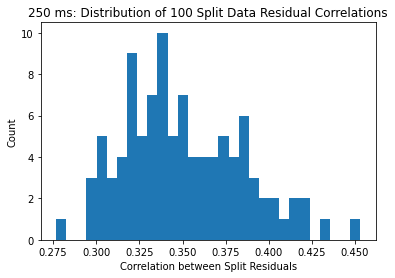

0.3505401084816734


In [905]:
lst_100_split_250_corrs = [elem[0] for elem in normalized_lst_100_split_corrs]

plt.hist(lst_100_split_250_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'250 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_250_corrs)))

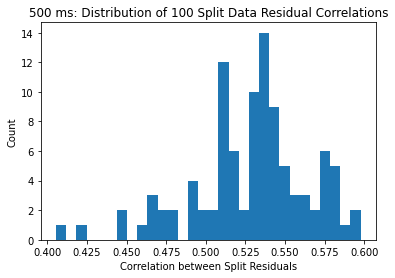

0.5285616780960296


In [906]:
lst_100_split_500_corrs = [elem[1] for elem in normalized_lst_100_split_corrs]

plt.hist(lst_100_split_500_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'500 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_500_corrs)))

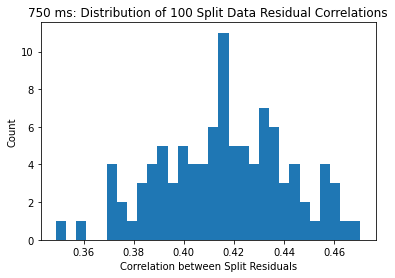

0.41595377737791495


In [907]:
lst_100_split_750_corrs = [elem[2] for elem in normalized_lst_100_split_corrs]

plt.hist(lst_100_split_750_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'750 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_750_corrs)))

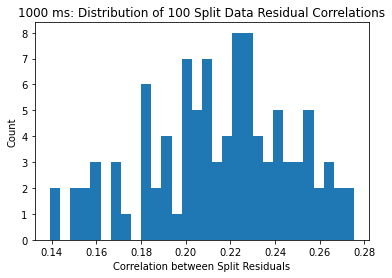

0.2152212892804183


In [908]:
lst_100_split_1000_corrs = [elem[3] for elem in normalized_lst_100_split_corrs]

plt.hist(lst_100_split_1000_corrs, density = False, bins=30)
plt.xlabel('Correlation between Split Residuals')
plt.ylabel('Count')
plt.title(r'1000 ms: Distribution of 100 Split Data Residual Correlations')
plt.show()

print(np.mean(np.array(lst_100_split_1000_corrs)))

#### Compare Mean Correlations Across Range of Split Sizes

In [909]:
fraction_50_duration_corrs = [lst_100_split_250_corrs,
                              lst_100_split_500_corrs,
                              lst_100_split_750_corrs,
                              lst_100_split_1000_corrs]


means_fraction_50 = [np.mean(np.array(elem)) for elem in fraction_50_duration_corrs]
means_fraction_50

[0.3505401084816734,
 0.5285616780960296,
 0.41595377737791495,
 0.2152212892804183]

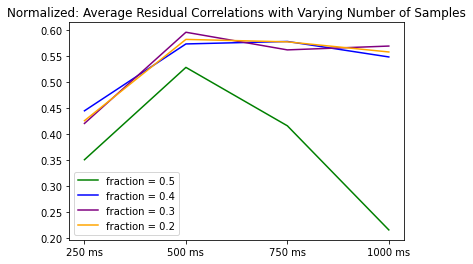

In [910]:
durations = ['250 ms', '500 ms', '750 ms', '1000 ms']
plt.plot(durations, means_fraction_50, color = 'green', label= 'fraction = 0.5')
plt.plot(durations, means_fraction_40, color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, means_fraction_30, color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, means_fraction_20, color = 'orange', label= 'fraction = 0.2')
plt.title('Normalized: Average Residual Correlations with Varying Number of Samples')
plt.legend()
plt.show()

In [ ]:
raw_split = data_split(raw_postOutlier_data)
normalized_split = data_split(normalized_postOutlier_data)

In [139]:
raw_split1_pivot = trial_pivotTable(raw_split[0])
raw_split2_pivot = trial_pivotTable(raw_split[1])

normalized_split1_pivot = trial_pivotTable(normalized_split[0])
normalized_split2_pivot = trial_pivotTable(normalized_split[1])

In [140]:
split1_raw_final = trial_getxy(raw_split1_pivot)
split2_raw_final = trial_getxy(raw_split2_pivot)

split1_normalized_final = trial_getxy(normalized_split1_pivot)
split2_normalized_final = trial_getxy(normalized_split2_pivot)

### Prep Raw Data Splits

#### Split 1

In [279]:
split1_raw_plot_data = split1_raw_final

## Execute this cell to prep for plotting
split1_final_x_250 = split1_raw_plot_data[0][0]
split1_final_y_250 = split1_raw_plot_data[1][0]
split1_ste_250 = split1_raw_plot_data[2][0]
split1_stim_250 = split1_raw_plot_data[3][0]

split1_final_x_500 = split1_raw_plot_data[0][1]
split1_final_y_500 = split1_raw_plot_data[1][1]
split1_ste_500 = split1_raw_plot_data[2][1]
split1_stim_500 = split1_raw_plot_data[3][1]

split1_final_x_750 = split1_raw_plot_data[0][2]
split1_final_y_750 = split1_raw_plot_data[1][2]
split1_ste_750 = split1_raw_plot_data[2][2]
split1_stim_750 = split1_raw_plot_data[3][2]

split1_final_x_1000 = split1_raw_plot_data[0][3]
split1_final_y_1000 = split1_raw_plot_data[1][3]
split1_ste_1000 = split1_raw_plot_data[2][3]
split1_stim_1000 = split1_raw_plot_data[3][3]

#### Split 2

In [280]:
split2_raw_plot_data = split2_raw_final

## Execute this cell to prep for plotting
split2_final_x_250 = split2_raw_plot_data[0][0]
split2_final_y_250 = split2_raw_plot_data[1][0]
split2_ste_250 = split2_raw_plot_data[2][0]
split2_stim_250 = split2_raw_plot_data[3][0]

split2_final_x_500 = split2_raw_plot_data[0][1]
split2_final_y_500 = split2_raw_plot_data[1][1]
split2_ste_500 = split2_raw_plot_data[2][1]
split2_stim_500 = split2_raw_plot_data[3][1]

split2_final_x_750 = split2_raw_plot_data[0][2]
split2_final_y_750 = split2_raw_plot_data[1][2]
split2_ste_750 = split2_raw_plot_data[2][2]
split2_stim_750 = split2_raw_plot_data[3][2]

split2_final_x_1000 = split2_raw_plot_data[0][3]
split2_final_y_1000 = split2_raw_plot_data[1][3]
split2_ste_1000 = split2_raw_plot_data[2][3]
split2_stim_1000 = split2_raw_plot_data[3][3]

m: [0.35056912]
b: 1.3112977908381944
R-squared:  0.3306982044386483


Text(0, 0.5, 'Residual')

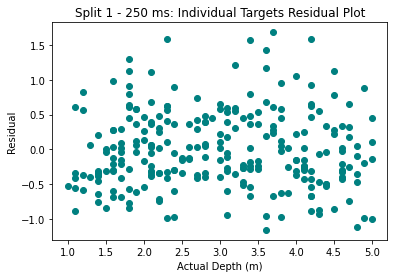

In [281]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_250).reshape(-1,1)
y = split1_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_250_residuals = y-y_predicted
plt.plot(X,split1_250_residuals, 'o', color='teal')
plt.title("Split 1 - 250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.3087227]
b: 1.340438184156521
R-squared:  0.20154419288339054


Text(0, 0.5, 'Residual')

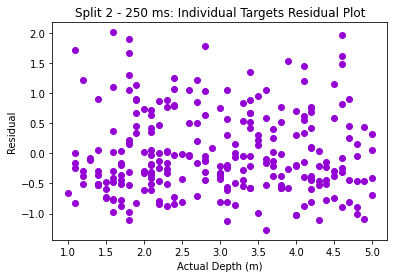

In [282]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_250).reshape(-1,1)
y = split2_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_250_residuals = y-y_predicted
plt.plot(X,split2_250_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

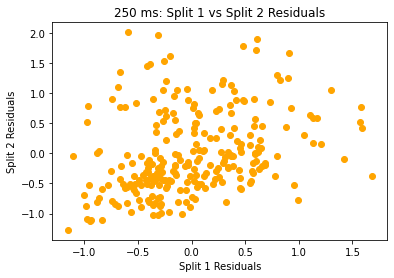

In [283]:
plt.plot(split1_250_residuals,split2_250_residuals, 'o', color='orange')
plt.title("250 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 250 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [284]:
import scipy

scipy.stats.pearsonr(split1_250_residuals, split2_250_residuals) 

(0.31934886230306614, 1.8717607396874407e-07)

m: [0.37124277]
b: 1.2389879205913847
R-squared:  0.31144575398090857


Text(0, 0.5, 'Residual')

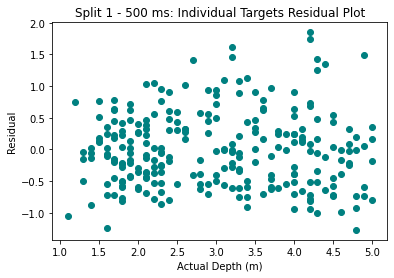

In [285]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_500).reshape(-1,1)
y = split1_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_500_residuals = y-y_predicted
plt.plot(X,split1_500_residuals, 'o', color='teal')
plt.title("Split 1 - 500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.40635776]
b: 1.1204485969449758
R-squared:  0.26511672791467966


Text(0, 0.5, 'Residual')

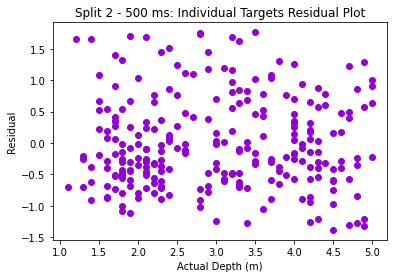

In [286]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_500).reshape(-1,1)
y = split2_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_500_residuals = y-y_predicted
plt.plot(X,split2_500_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

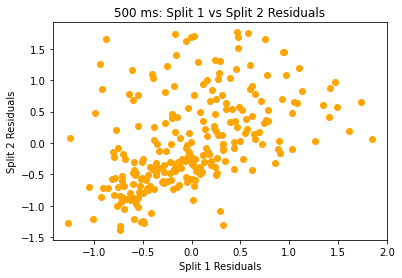

In [287]:
plt.plot(split1_500_residuals,split2_500_residuals, 'o', color='orange')
plt.title("500 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 500 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [288]:
import scipy

scipy.stats.pearsonr(split1_500_residuals, split2_500_residuals) 

(0.47369565426246885, 1.918174760944417e-15)

m: [0.45605423]
b: 1.059745391040898
R-squared:  0.4336269626634519


Text(0, 0.5, 'Residual')

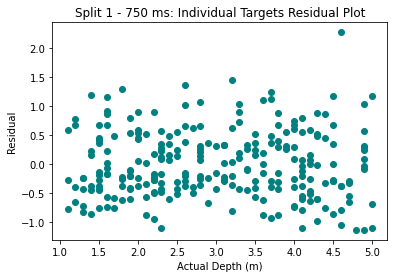

In [289]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_750).reshape(-1,1)
y = split1_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_750_residuals = y-y_predicted
plt.plot(X,split1_750_residuals, 'o', color='teal')
plt.title("Split 1 - 750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.49920032]
b: 0.870900935192122
R-squared:  0.40097741397807296


Text(0, 0.5, 'Residual')

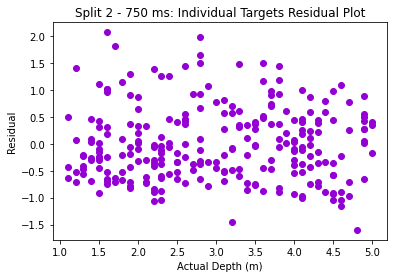

In [292]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_750).reshape(-1,1)
y = split2_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_750_residuals = y-y_predicted
plt.plot(X,split2_750_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

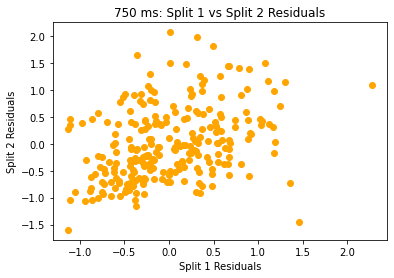

In [293]:
plt.plot(split1_750_residuals,split2_750_residuals, 'o', color='orange')
plt.title("750 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 750 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [294]:
import scipy

scipy.stats.pearsonr(split1_750_residuals, split2_750_residuals) 

(0.3723662190753076, 1.0434878795812323e-09)

m: [0.48156756]
b: 0.9583343127897177
R-squared:  0.44666382883152145


Text(0, 0.5, 'Residual')

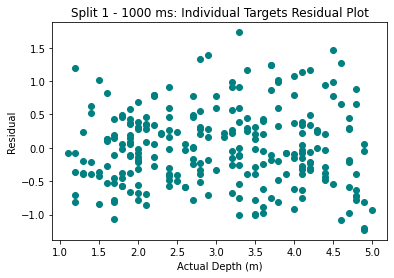

In [295]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_1000).reshape(-1,1)
y = split1_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_1000_residuals = y-y_predicted
plt.plot(X,split1_1000_residuals, 'o', color='teal')
plt.title("Split 1 - 1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.49258701]
b: 0.8886509418924327
R-squared:  0.34668010753665435


Text(0, 0.5, 'Residual')

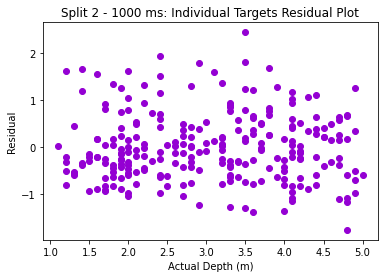

In [296]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_1000).reshape(-1,1)
y = split2_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_1000_residuals = y-y_predicted
plt.plot(X,split2_1000_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

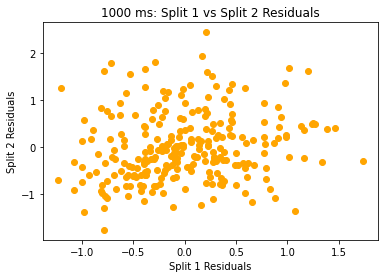

In [297]:
plt.plot(split1_1000_residuals,split2_1000_residuals, 'o', color='orange')
plt.title("1000 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 1000 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [298]:
import scipy

scipy.stats.pearsonr(split1_1000_residuals, split2_1000_residuals) 

(0.17428722936539395, 0.005533201329248741)

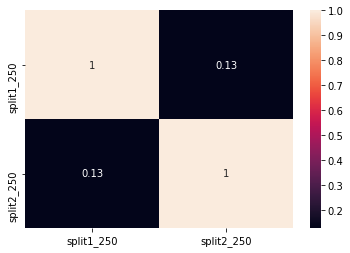

In [708]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

split1 = [split1_250_residuals, split1_500_residuals, split1_750_residuals, split1_1000_residuals]
split2 = [split2_250_residuals, split2_500_residuals, split2_750_residuals, split2_1000_residuals]

import pandas as pd

data = {'split1_250': split1_250_residuals,
        'split2_250': split2_250_residuals
        }

df = pd.DataFrame(data,columns=['split1_250','split2_250'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

##### 500 ms

### Prep Normalized Data Splits

#### Split 1

In [299]:
split1_normalized_plot_data = split1_normalized_final

## Execute this cell to prep for plotting
split1_final_x_250 = split1_normalized_plot_data[0][0]
split1_final_y_250 = split1_normalized_plot_data[1][0]
split1_ste_250 = split1_normalized_plot_data[2][0]
split1_stim_250 = split1_normalized_plot_data[3][0]

split1_final_x_500 = split1_normalized_plot_data[0][1]
split1_final_y_500 = split1_normalized_plot_data[1][1]
split1_ste_500 = split1_normalized_plot_data[2][1]
split1_stim_500 = split1_normalized_plot_data[3][1]

split1_final_x_750 = split1_normalized_plot_data[0][2]
split1_final_y_750 = split1_normalized_plot_data[1][2]
split1_ste_750 = split1_normalized_plot_data[2][2]
split1_stim_750 = split1_normalized_plot_data[3][2]

split1_final_x_1000 = split1_normalized_plot_data[0][3]
split1_final_y_1000 = split1_normalized_plot_data[1][3]
split1_ste_1000 = split1_normalized_plot_data[2][3]
split1_stim_1000 = split1_normalized_plot_data[3][3]

#### Split 2

In [300]:
split2_normalized_plot_data = split2_normalized_final

## Execute this cell to prep for plotting
split2_final_x_250 = split2_normalized_plot_data[0][0]
split2_final_y_250 = split2_normalized_plot_data[1][0]
split2_ste_250 = split2_normalized_plot_data[2][0]
split2_stim_250 = split2_normalized_plot_data[3][0]

split2_final_x_500 = split2_normalized_plot_data[0][1]
split2_final_y_500 = split2_normalized_plot_data[1][1]
split2_ste_500 = split2_normalized_plot_data[2][1]
split2_stim_500 = split2_normalized_plot_data[3][1]

split2_final_x_750 = split2_normalized_plot_data[0][2]
split2_final_y_750 = split2_normalized_plot_data[1][2]
split2_ste_750 = split2_normalized_plot_data[2][2]
split2_stim_750 = split2_normalized_plot_data[3][2]

split2_final_x_1000 = split2_normalized_plot_data[0][3]
split2_final_y_1000 = split2_normalized_plot_data[1][3]
split2_ste_1000 = split2_normalized_plot_data[2][3]
split2_stim_1000 = split2_normalized_plot_data[3][3]

m: [0.13534643]
b: 0.5681646767979667
R-squared:  0.3333328669248301


Text(0, 0.5, 'Residual')

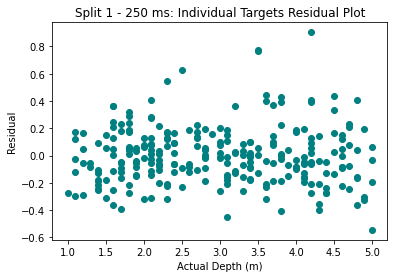

In [301]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_250).reshape(-1,1)
y = split1_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_250_residuals = y-y_predicted
plt.plot(X,split1_250_residuals, 'o', color='teal')
plt.title("Split 1 - 250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.15444093]
b: 0.5108314120958558
R-squared:  0.44040809180763474


Text(0, 0.5, 'Residual')

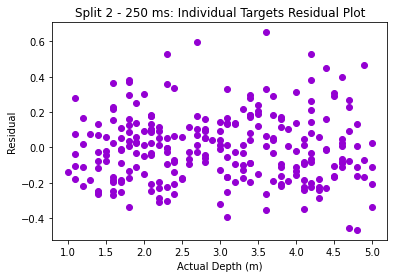

In [302]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_250).reshape(-1,1)
y = split2_final_y_250
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_250_residuals = y-y_predicted
plt.plot(X,split2_250_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 250 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

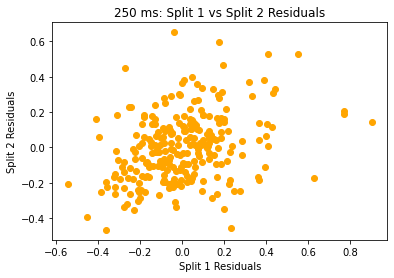

In [303]:
plt.plot(split1_250_residuals,split2_250_residuals, 'o', color='orange')
plt.title("250 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 250 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [304]:
import scipy
print("Normalized 250 ms Residuals Correlations")
scipy.stats.pearsonr(split1_250_residuals, split2_250_residuals) 

Normalized 250 ms Residuals Correlations


(0.3422718357455883, 2.033605018325253e-08)

m: [0.16580234]
b: 0.5042372744803728
R-squared:  0.3548123338840282


Text(0, 0.5, 'Residual')

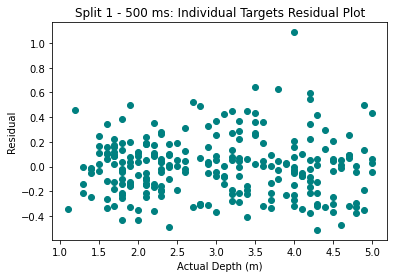

In [305]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_500).reshape(-1,1)
y = split1_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_500_residuals = y-y_predicted
plt.plot(X,split1_500_residuals, 'o', color='teal')
plt.title("Split 1 - 500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.17826039]
b: 0.4528169563605483
R-squared:  0.42848992766860583


Text(0, 0.5, 'Residual')

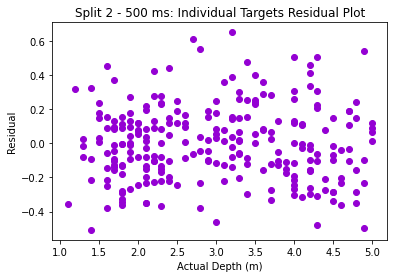

In [306]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_500).reshape(-1,1)
y = split2_final_y_500
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_500_residuals = y-y_predicted
plt.plot(X,split2_500_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 500 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

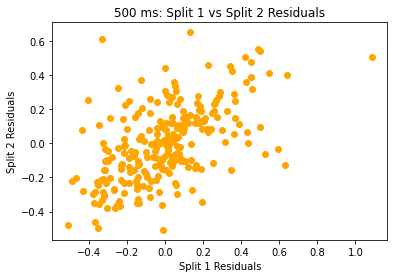

In [307]:
plt.plot(split1_500_residuals,split2_500_residuals, 'o', color='orange')
plt.title("500 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 500 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [308]:
import scipy

print("Normalized 500 ms Residuals Correlations")
scipy.stats.pearsonr(split1_500_residuals, split2_500_residuals) 

Normalized 500 ms Residuals Correlations


(0.5570628346962133, 7.335741910134947e-22)

m: [0.19055775]
b: 0.4506869449533639
R-squared:  0.425538587572988


Text(0, 0.5, 'Residual')

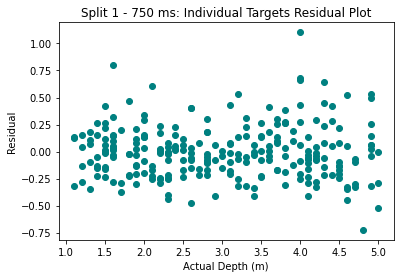

In [309]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_750).reshape(-1,1)
y = split1_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_750_residuals = y-y_predicted
plt.plot(X,split1_750_residuals, 'o', color='teal')
plt.title("Split 1 - 750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.23245499]
b: 0.3221890290385483
R-squared:  0.5748842129438128


Text(0, 0.5, 'Residual')

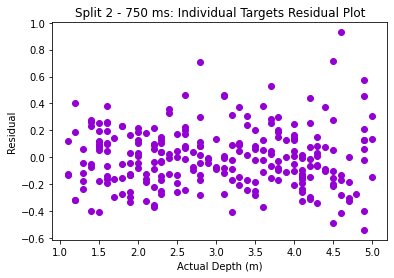

In [310]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_750).reshape(-1,1)
y = split2_final_y_750
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_750_residuals = y-y_predicted
plt.plot(X,split2_750_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 750 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

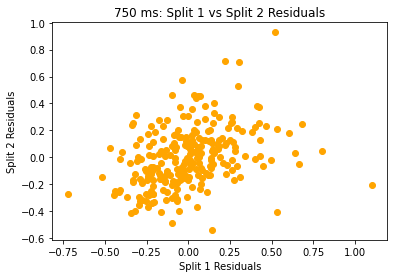

In [311]:
plt.plot(split1_750_residuals,split2_750_residuals, 'o', color='orange')
plt.title("750 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 750 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [312]:
import scipy

print("Normalized 750 ms Residuals Correlations")
scipy.stats.pearsonr(split1_750_residuals, split2_750_residuals) 

Normalized 750 ms Residuals Correlations


(0.35877755774347453, 4.532841056478876e-09)

m: [0.20894429]
b: 0.3815598401219322
R-squared:  0.42698865794693586


Text(0, 0.5, 'Residual')

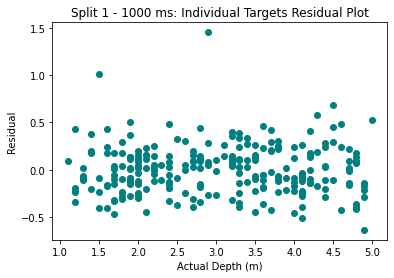

In [313]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split1_stim_1000).reshape(-1,1)
y = split1_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split1_1000_residuals = y-y_predicted
plt.plot(X,split1_1000_residuals, 'o', color='teal')
plt.title("Split 1 - 1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

m: [0.23344587]
b: 0.312404904305423
R-squared:  0.5695146116838892


Text(0, 0.5, 'Residual')

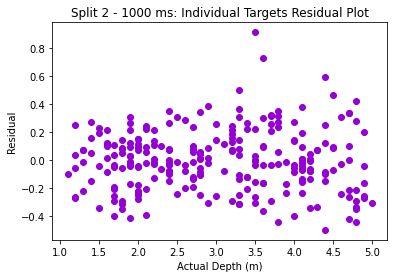

In [314]:
from sklearn.linear_model import LinearRegression
#run regression
X = np.array(split2_stim_1000).reshape(-1,1)
y = split2_final_y_1000
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))
print("b: {0}".format(reg.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y))

split2_1000_residuals = y-y_predicted
plt.plot(X,split2_1000_residuals, 'o', color='darkviolet')
plt.title("Split 2 - 1000 ms: Individual Targets Residual Plot")
plt.xlabel("Actual Depth (m)")
plt.ylabel("Residual")

Text(0, 0.5, 'Split 2 Residuals')

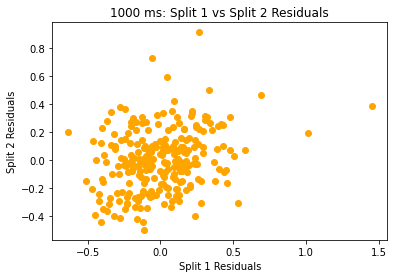

In [315]:
plt.plot(split1_1000_residuals,split2_1000_residuals, 'o', color='orange')
plt.title("1000 ms: Split 1 vs Split 2 Residuals")
plt.xlabel("Split 1 Residuals")
plt.ylabel("Split 2 Residuals")

#### 1000 ms Split Residual Correlation

https://realpython.com/numpy-scipy-pandas-correlation-python/

In [169]:
import scipy

print("Normalized 1000 ms Residuals Correlations")
scipy.stats.pearsonr(split1_1000_residuals, split2_1000_residuals) 

Normalized 1000 ms Residuals Correlations


(0.28024303991067395, 6.258862210085696e-06)

### Next Steps:
- need to get residuals for all of the plots
- look into matplotlib residual calculation